<a href="https://colab.research.google.com/github/fiorellaviani3009/OnlineRetailAnalysis-FiorellaViani/blob/main/Online_Retail_Analysis_Fiorella_Viani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Online Retail II — Sales Analysis
**Author:** Fiorella Viani  
**Dataset:** UCI Online Retail II  
**Period:** 2009–2011  
**Tool:** Python (pandas, matplotlib, seaborn)

## Objectives:
- Compare revenue and pricing across years and months
- Identify seasonal patterns and sales peaks
- Detect low-activity periods (holidays, etc.)
- Find products that sustain positive revenue balance
- Deliver actionable insights for business decision-making

## About this notebook
Every step in this analysis is fully documented — including the reasoning behind each decision.
This is intentional: whether you're a fellow analyst reviewing the methodology, or someone
evaluating the work, you should be able to follow the logic without needing to ask why something
was done. Data speaks clearly when the process behind it does too.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Libraries - All good")

Libraries - All good


In [ ]:
# There´s two pages on the dataset I´m analyzing so I´ll have to merge them together.
df_0910 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2009-2010')
df_1011 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')

df = pd.concat([df_0910, df_1011], ignore_index=True)

print(f"Shape hoja 2009-2010: {df_0910.shape}")
print(f"Shape hoja 2010-2011: {df_1011.shape}")
print(f"Shape total combinado: {df.shape}")
print(f"\nColumnas: {df.columns.tolist()}")

Shape hoja 2009-2010: (525461, 8)
Shape hoja 2010-2011: (541910, 8)
Shape total combinado: (1067371, 8)

Columnas: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']


## 1. Initial Data Exploration
Before any cleaning, we inspect structure, data types, and basic statistics to understand what we're working with.

In [ ]:

print("SHAPE;")
print(f"{df.shape[0]:,} rows × {df.shape[1]} columns")

print("\n DATA TYPES & NON-NULL COUNTS;")
print(df.info())


print("\n MISSING VALUES;")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing': missing,
    '% of Total': missing_pct
}).query('Missing > 0')
print(missing_df)


print("\n DUPLICATES;")
print(f"Duplicate rows: {df.duplicated().sum():,}")


print("\n NUMERIC SUMMAR;Y")
print(df.describe())

print("\n FIRST FIVE ROWS;")
print(df.head())

SHAPE;
1,067,371 rows × 8 columns

 DATA TYPES & NON-NULL COUNTS;
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB
None

 MISSING VALUES;
             Missing  % of Total
Description     4382        0.41
Customer ID   243007       22.77

 DUPLICATES;
Duplicate rows: 34,335

 NUMERIC SUMMAR;Y
        Quantity                    InvoiceDate     

## 2. Data Quality Assessment

Before modifying anything, we document every issue found and the reasoning behind each decision.
This is a critical step in any professional analysis — changes to raw data must always be justified.

| Issue | Detail | Decision & Reasoning |
|-------|--------|----------------------|
| Missing `Description` | 4,382 rows (0.41%) | **Drop** — without a product name, the row can't be used in product-level analysis |
| Missing `Customer ID` | 243,007 rows (22.77%) | **Keep** — these are valid transactions, just anonymous. Dropping them would lose 22% of revenue data |
| Duplicate rows | 34,335 | **Drop** — fully identical rows provide no additional information and would skew aggregations |
| Negative `Quantity` | Min: -80,995 | **Separate** — these are returns/refunds. Valid business data but must be analyzed independently |
| Negative `Price` | Min: -53,594.36 | **Investigate first** — could be manual adjustments, errors, or discounts. Decision after inspection |
| `Customer ID` dtype: float64 | e.g. 13085.0 | **Convert to string** — it's an identifier, not a numeric value. The decimal is a pandas artifact |
| Invoices starting with `'C'` | Mixed with sales | **Separate** — 'C' prefix explicitly marks cancellations in this dataset's convention |

Now I'll proceed to apply these fixes in a specific order, since not all issues carry the same weight.
Some of them are **structural blockers** that affect every subsequent step — if left untreated,
they would corrupt aggregations, skew statistics, or produce misleading results downstream.

**Priority order and reasoning:**
1. **Duplicates** — must go first. Duplicate rows inflate counts and totals, which would make every following metric unreliable.
2. **Missing Description** — removed before any product-level operation. A row without a product name is unidentifiable.
3. **Customer ID dtype** — converted before any customer segmentation or grouping attempt.
4. **Cancellations ('C' invoices)** — separated before revenue calculations. Mixing returns with sales would understate true performance.
5. **Remaining negative Quantity** — cleaned after cancellations, as a second safety net for data entry errors.
6. **Zero / negative Price** — investigated last, since we first need to understand what these rows actually represent before deciding whether to drop or keep them.

In [ ]:
# 1. DROP DUPLICATES
# Fully identical rows add no information and distort aggregations
df.drop_duplicates(inplace=True)
print(f"After dropping duplicates: {df.shape[0]:,} rows")

# 2. DROP MISSING DESCRIPTION
# Rows without a product name cannot be used in product-level analysis
df.dropna(subset=['Description'], inplace=True)
print(f"After dropping missing Description: {df.shape[0]:,} rows")

# 3. CONVERT Customer ID → string
# Customer ID is an identifier, not a numeric value.
# pandas read it as float64 due to NaNs — we strip the decimal and treat unknowns explicitly.
df['Customer ID'] = df['Customer ID'].astype('Int64').astype(str)
df['Customer ID'] = df['Customer ID'].replace('<NA>', 'Unknown')
print(f"Customer ID dtype: {df['Customer ID'].dtype}")

# 4. SEPARATE CANCELLATIONS
# Invoices prefixed with 'C' are cancellations by dataset convention.
# We isolate them for potential return-rate analysis rather than dropping them entirely.
cancellations = df[df['Invoice'].astype(str).str.startswith('C')].copy()
df_clean = df[~df['Invoice'].astype(str).str.startswith('C')].copy()

print(f"\nCancellations separated: {len(cancellations):,} rows")
print(f"Clean sales transactions: {len(df_clean):,} rows")

# 5. REMOVE REMAINING NEGATIVE QUANTITY
# Any remaining negative quantities not caught by the 'C' filter are likely data entry errors
neg_qty = df_clean[df_clean['Quantity'] <= 0]
df_clean = df_clean[df_clean['Quantity'] > 0]
print(f"Additional non-positive quantity rows removed: {len(neg_qty):,}")

# 6. INVESTIGATE NEGATIVE / ZERO PRICES
# Before dropping, we inspect these rows — they may be legitimate adjustments or test entries
neg_price = df_clean[df_clean['Price'] <= 0]
print(f"\nRows with Price <= 0: {len(neg_price):,}")
print(neg_price[['Invoice','StockCode','Description','Quantity','Price']].head(10))

After dropping duplicates: 1,033,036 rows
After dropping missing Description: 1,028,761 rows
Customer ID dtype: object

Cancellations separated: 19,104 rows
Clean sales transactions: 1,009,657 rows
Additional non-positive quantity rows removed: 760

Rows with Price <= 0: 984
      Invoice StockCode                      Description  Quantity  Price
4674   489825     22076               6 RIBBONS EMPIRE          12   0.00
5904   489861       DOT                   DOTCOM POSTAGE         1   0.00
6781   489998     48185              DOOR MAT FAIRY CAKE         2   0.00
16107  490727         M                           Manual         1   0.00
18738  490961     22065   CHRISTMAS PUDDING TRINKET POT          1   0.00
18739  490961     22142     CHRISTMAS CRAFT WHITE FAIRY         12   0.00
31993  491971     85042        ANTIQUE LILY FAIRY LIGHTS         1   0.00
32916  492079     85042        ANTIQUE LILY FAIRY LIGHTS         8   0.00
40101  492760     21143  ANTIQUE GLASS HEART DECORATION   

### Handling Zero & Negative Prices

Inspecting the 984 rows with `Price <= 0`, we can identify a clear pattern:
- `DOTCOM POSTAGE` and `Manual` entries are internal/administrative records, not actual sales
- Zero-price product rows appear to be data entry errors or samples with no commercial value
- None of these represent a real transaction from a business analysis standpoint

**Decision: Drop all rows where `Price <= 0`**  
Keeping them would introduce zeros into revenue calculations, distorting averages,
totals, and any price-based metric across the entire analysis.

In [ ]:
# 7. DROP ZERO & NEGATIVE PRICES
# Administrative entries, postage records, and data entry errors.
# None represent actual sales — keeping them would corrupt revenue metrics.
df_clean = df_clean[df_clean['Price'] > 0].copy()
print(f"After removing zero/negative prices: {df_clean.shape[0]:,} rows")

# 8. CREATE REVENUE COLUMN
# Revenue = Quantity × Price per unit.
# This is our core business metric for all subsequent analysis.
df_clean['Revenue'] = df_clean['Quantity'] * df_clean['Price']

#  9. EXTRACT DATE FEATURES
# Breaking InvoiceDate into components allows time-based aggregations
# without repeated parsing throughout the analysis.
df_clean['Year']    = df_clean['InvoiceDate'].dt.year
df_clean['Month']   = df_clean['InvoiceDate'].dt.month
df_clean['Hour']    = df_clean['InvoiceDate'].dt.hour
df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.day_name()

#  10. FINAL CLEAN DATASET SUMMARY
print("\n" + "=" * 50)
print("FINAL CLEAN DATASET")
print("=" * 50)
print(f"Rows: {df_clean.shape[0]:,}")
print(f"Columns: {df_clean.shape[1]}")
print(f"\nDate range: {df_clean['InvoiceDate'].min().date()} → {df_clean['InvoiceDate'].max().date()}")
print(f"Years covered: {sorted(df_clean['Year'].unique())}")
print(f"Countries: {df_clean['Country'].nunique()}")
print(f"Unique products: {df_clean['Description'].nunique():,}")
print(f"Unique customers (excl. Unknown): {df_clean[df_clean['Customer ID'] != 'Unknown']['Customer ID'].nunique():,}")
print(f"\nTotal Revenue in dataset: £{df_clean['Revenue'].sum():,.2f}")
print(f"Average order value: £{df_clean.groupby('Invoice')['Revenue'].sum().mean():,.2f}")

print("\n" + "=" * 50)
print("CLEANED DATA SAMPLE")
print("=" * 50)
print(df_clean.head())

After removing zero/negative prices: 1,007,913 rows

FINAL CLEAN DATASET
Rows: 1,007,913
Columns: 13

Date range: 2009-12-01 → 2011-12-09
Years covered: [np.int32(2009), np.int32(2010), np.int32(2011)]
Countries: 43
Unique products: 5,399
Unique customers (excl. Unknown): 5,878

Total Revenue in dataset: £20,476,260.45
Average order value: £510.92

CLEANED DATA SAMPLE
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price Customer ID         Country  Revenue  Year  \
0 2009-12-01 07:45:00   6.95       13085  United Kingdom    83.40  2009   
1 2009-12-01 07:45:00   6.75       13085  United Kingdom  

### A note on data coverage — why calendar completeness matters

While exploring the dataset's time range, I identified a structural issue that directly affects
the core objective of this analysis: **year-over-year comparison**.

The dataset spans from December 1, 2009 to December 9, 2011. At first glance this looks like
two full years of data — but it isn't:

- **2009** contains only December (1 month)
- **2010** contains January through December (12 months — the only full year)
- **2011** contains January through early December (incomplete)

Comparing total revenue or transaction volume across these years as-is would be misleading.
2009 would always appear as the weakest year — not because business was slow,
but simply because we only have 31 days of data.

**My proposed approach:**
Rather than force an uneven comparison, I'll trim the dataset to only include
months that are fully represented across both comparable years.
Specifically: **drop 2009 entirely, and exclude December from both 2010 and 2011** —
leaving a clean January–November window for each year.

This way, every month in the comparison exists in both years with the same opportunity
to generate transactions, making year-over-year and month-over-month analysis
statistically honest.

In [ ]:
# Inspect exact data coverage per year and month
coverage = df_clean.groupby(['Year', 'Month']).agg(
    Transactions=('Invoice', 'nunique'),
    Revenue=('Revenue', 'sum')
).reset_index()

print(coverage.to_string(index=False))

print("\n" + "=" * 50)
print("ROWS PER YEAR")
print("=" * 50)
print(df_clean.groupby('Year').agg(
    Rows=('Invoice', 'count'),
    Transactions=('Invoice', 'nunique'),
    Revenue=('Revenue', 'sum')
).round(2))

print("\n" + "=" * 50)
print("DECEMBER COVERAGE CHECK")
print("=" * 50)
dec = df_clean[df_clean['Month'] == 12]
print(dec.groupby(['Year', 'Month']).agg(
    Last_date=('InvoiceDate', 'max'),
    Transactions=('Invoice', 'nunique'),
    Revenue=('Revenue', 'sum')
))

 Year  Month  Transactions    Revenue
 2009     12          1682  822483.95
 2010      1          1105  651155.11
 2010      2          1201  551504.73
 2010      3          1681  830915.26
 2010      4          1462  678875.25
 2010      5          1500  657705.50
 2010      6          1645  749537.31
 2010      7          1529  648810.27
 2010      8          1425  695251.91
 2010      9          1839  921696.99
 2010     10          2301 1161902.22
 2010     11          2747 1464293.14
 2010     12          1559  821452.73
 2011      1          1086  689811.61
 2011      2          1100  522545.56
 2011      3          1454  716215.26
 2011      4          1246  536968.49
 2011      5          1681  769296.61
 2011      6          1533  760547.01
 2011      7          1475  718076.12
 2011      8          1361  757841.38
 2011      9          1837 1056435.19
 2011     10          2040 1151263.73
 2011     11          2769 1503866.78
 2011     12           819  637808.33

ROWS PER YE

### Coverage analysis results & final decision on time scope

After inspecting the exact transaction counts and revenue per month, the picture is clearer:

| Year | Coverage | Transactions | Revenue |
|------|----------|-------------|---------|
| 2009 | December only | 1,682 | £822,483 |
| 2010 | January – December (full) | 19,994 | £9,833,100 |
| 2011 | January – December 9th (incomplete) | 18,401 | £9,820,676 |

**Key observations:**

- **December 2009 vs December 2010** are comparable: both run until the 23rd and have
similar transaction volumes (1,682 vs 1,559) and nearly identical revenue (£822K vs £821K).
This makes December 2009 a valid isolated reference point for seasonal comparison.

- **December 2011 is not usable for comparison**: only 9 days of data, 819 transactions —
roughly half the volume of the other Decembers. Including it would introduce systematic
bias into any monthly or seasonal pattern analysis.

**Final decision on time scope:**

Rather than a simple year filter, I'll apply a **precise date-based cutoff**:

- **Keep:** December 2009 (full comparable month) + all of 2010 + January–November 2011
- **Drop:** December 2011 (incomplete — only 9 days, high risk of bias)

This approach maximizes the usable data while ensuring every time window included
in the analysis is statistically honest.

> *Using incomplete periods in time-series analysis doesn't just affect descriptive statistics —
> it can propagate bias into any predictive model trained on this data downstream.
> A truncated December would systematically underrepresent end-of-year patterns,
> leading a model to underestimate Q4 performance.*

In [ ]:
# APPLY FINAL TIME SCOPE FILTER
# Keep: Dec 2009 + full 2010 + Jan–Nov 2011
# Drop: Dec 2011 (only 9 days — statistically unreliable)
df_clean = df_clean[~((df_clean['Year'] == 2011) & (df_clean['Month'] == 12))].copy()

print("Final dataset after time scope filter:")
print(f"Rows: {df_clean.shape[0]:,}")
print(f"\nCoverage:")
print(df_clean.groupby(['Year','Month']).agg(
    Transactions=('Invoice','nunique'),
    Revenue=('Revenue','sum')
).round(2).to_string())

Final dataset after time scope filter:
Rows: 983,079

Coverage:
            Transactions    Revenue
Year Month                         
2009 12             1682  822483.95
2010 1              1105  651155.11
     2              1201  551504.73
     3              1681  830915.26
     4              1462  678875.25
     5              1500  657705.50
     6              1645  749537.31
     7              1529  648810.27
     8              1425  695251.91
     9              1839  921696.99
     10             2301 1161902.22
     11             2747 1464293.14
     12             1559  821452.73
2011 1              1086  689811.61
     2              1100  522545.56
     3              1454  716215.26
     4              1246  536968.49
     5              1681  769296.61
     6              1533  760547.01
     7              1475  718076.12
     8              1361  757841.38
     9              1837 1056435.19
     10             2040 1151263.73
     11             2769 1503866.78


## 3. Cleaning Summary

The raw dataset required significant preparation before any analysis could begin.
Here's a complete record of every transformation applied and its impact:

| Step | Action | Rows Removed | Reason |
|------|--------|-------------|--------|
| 1 | Drop duplicates | 34,335 | Identical rows inflate all aggregations |
| 2 | Drop missing Description | 4,382 | Unidentifiable products |
| 3 | Convert Customer ID to string | — | Identifier, not a numeric value |
| 4 | Separate cancellations ('C' invoices) | 19,104 | Returns ≠ sales; kept for potential return-rate analysis |
| 5 | Remove non-positive Quantity | 760 | Data entry errors not caught by 'C' filter |
| 6 | Remove zero/negative Price | 984 | Administrative entries, not real transactions |
| 7 | Create Revenue column | — | Quantity × Price — core business metric |
| 8 | Extract date features | — | Year, Month, Hour, DayOfWeek for time-based analysis |
| 9 | Drop December 2011 | 24,658 | Only 9 days — statistically unreliable for comparison |

| | Count |
|-|-------|
| Raw rows | 1,067,371 |
| Final clean rows | 983,079 |
| Total removed | 84,292 (7.9%) |
| Years covered | 2009 (Dec) · 2010 (full) · 2011 (Jan–Nov) |
| Total Revenue | £19,838,452.12 |
| Unique products | 5,399 |
| Countries | 43 |
| Identified customers | 5,878 |

A removal rate of **7.9%** confirms the dataset was largely reliable.
Every decision above is documented and reproducible.

In [ ]:
#Just to check;
print(f"£{df_clean['Revenue'].sum():,.2f}")

£19,838,452.12


## 4. Analysis & Visualization

Data alone doesn't communicate — it informs.
A table of numbers is precise, but precision without clarity doesn't drive decisions.

The goal of this section is not just to show what the data contains, but to make it
immediately understandable to anyone reading this — whether they're a data analyst,
a business owner, or a stakeholder with no technical background.

Every chart in this section is built from the cleaned, verified data we prepared above.
The numbers are always there — but the visuals are what make the story land.

In [ ]:
#  GLOBAL VISUALIZATION SETTINGS
# Defined once here so every chart in the notebook shares
# the same style, fonts, and color palette consistently.

plt.rcParams.update({
    'figure.facecolor'  : 'white',
    'axes.facecolor'    : '#F8F9FA',
    'axes.grid'         : True,
    'grid.color'        : 'white',
    'grid.linewidth'    : 1.2,
    'font.family'       : 'sans-serif',
    'axes.titlesize'    : 14,
    'axes.titleweight'  : 'bold',
    'axes.labelsize'    : 11,
    'xtick.labelsize'   : 10,
    'ytick.labelsize'   : 10,
    'figure.titlesize'  : 16,
    'figure.titleweight': 'bold',
})

# Brand palette — used consistently across all charts
PALETTE = {
    'primary'   : '#1B3A6B',   # navy
    'secondary' : '#2E86AB',   # blue
    'accent'    : '#E84855',   # red (highlights, alerts)
    'positive'  : '#3BB273',   # green (good performance)
    'neutral'   : '#A8C8E8',   # light blue (backgrounds, secondary bars)
    'text'      : '#333333',
}

YEAR_COLORS = {
    2009: PALETTE['neutral'],
    2010: PALETTE['secondary'],
    2011: PALETTE['primary'],
}

print("Visual settings configured ✓")
print(f"Palette: {list(PALETTE.keys())}")

Visual settings configured ✓
Palette: ['primary', 'secondary', 'accent', 'positive', 'neutral', 'text']


## 5. Weekly Analysis

### 5.1 Sales peaks and low points by day of the week
Which days generate the most and least revenue?
Is there a consistent weekly rhythm to this business?

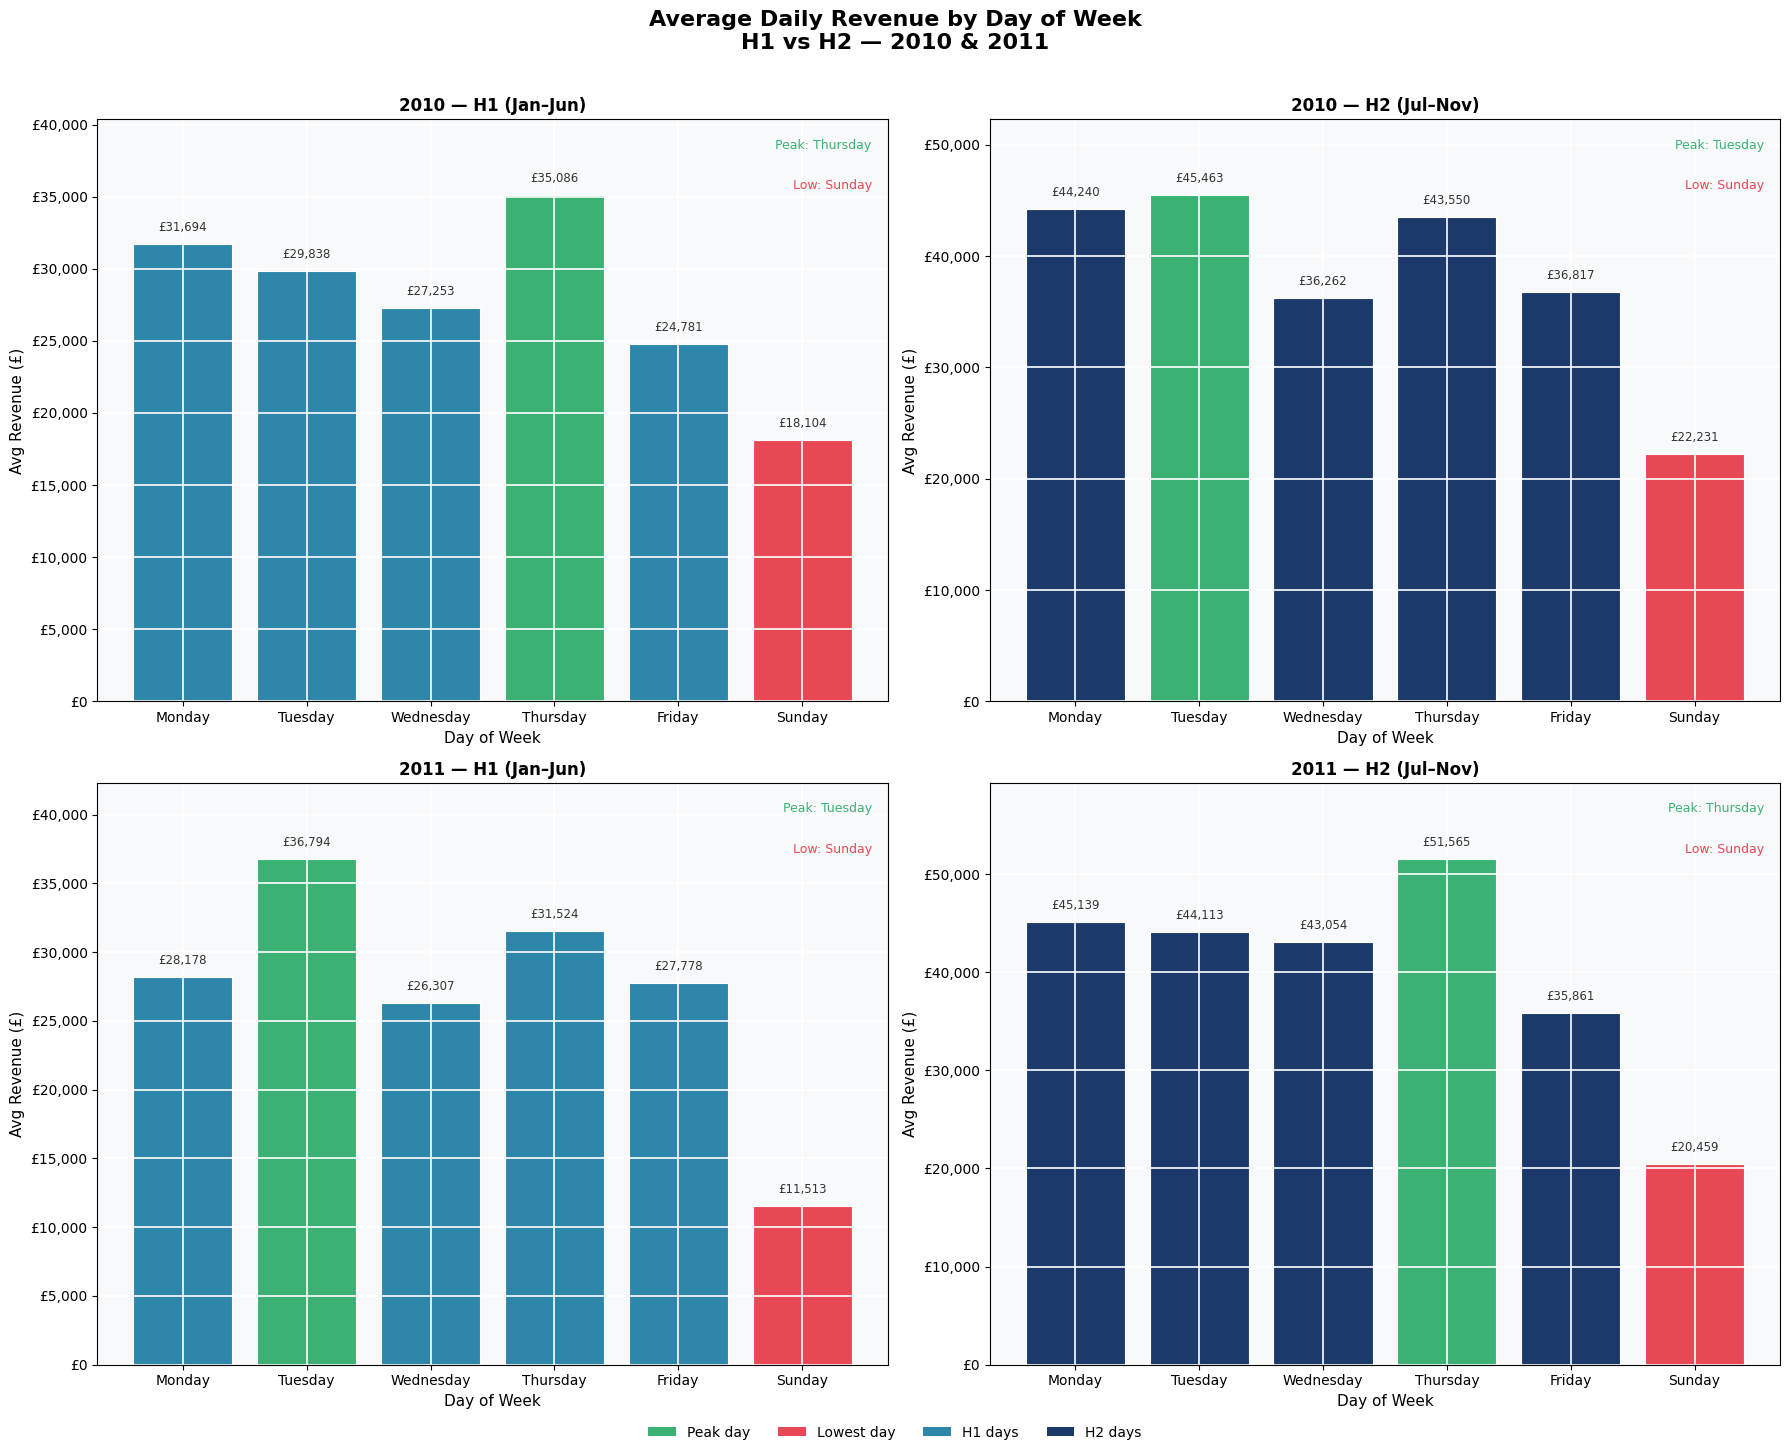


Average Revenue by Year / Half / Day:
Year              2010                      2011             
Half      H1 (Jan–Jun) H2 (Jul–Nov) H1 (Jan–Jun) H2 (Jul–Nov)
DayOfWeek                                                    
Monday        31694.04     44240.35     28177.81     45138.89
Tuesday       29837.67     45462.57     36794.36     44113.05
Wednesday     27252.83     36262.39     26306.66     43054.06
Thursday      35085.75     43549.82     31524.05     51564.93
Friday        24781.07     36817.28     27778.14     35860.82
Sunday        18103.66     22231.49     11513.50     20458.58


In [ ]:
# ── WEEKLY ANALYSIS — Point 1 ────────────────────────────────────
# We split each year into two halves to avoid masking seasonality
# with a single annual average.
# H1: January–June | H2: July–November
# This reveals whether the weekly pattern holds across the whole year
# or shifts depending on the time of year.

day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Sunday']

df_weekly = df_clean[df_clean['Year'].isin([2010, 2011])].copy()
df_weekly['Half'] = df_weekly['Month'].apply(lambda m: 'H1 (Jan–Jun)' if m <= 6 else 'H2 (Jul–Nov)')

# ── FIX: sum revenue per day first, then average across weeks ───
# This gives us average daily revenue (£thousands), not avg price per row
weekly = df_weekly.groupby(
    ['Year', 'Half', 'DayOfWeek',
     df_weekly['InvoiceDate'].dt.isocalendar().week]
)['Revenue'].sum().reset_index()

weekly = weekly.groupby(
    ['Year', 'Half', 'DayOfWeek']
)['Revenue'].mean().reset_index()

weekly['DayOfWeek'] = pd.Categorical(weekly['DayOfWeek'], categories=day_order, ordered=True)
weekly = weekly.sort_values(['Year', 'Half', 'DayOfWeek'])

# ── PLOT ─────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(18, 14), sharey=False)
fig.suptitle('Average Daily Revenue by Day of Week\nH1 vs H2 — 2010 & 2011', y=1.01)

half_colors = {
    'H1 (Jan–Jun)' : PALETTE['secondary'],
    'H2 (Jul–Nov)' : PALETTE['primary'],
}

for row, year in enumerate([2010, 2011]):
    for col, half in enumerate(['H1 (Jan–Jun)', 'H2 (Jul–Nov)']):
        ax = axes[row][col]
        data = weekly[(weekly['Year'] == year) & (weekly['Half'] == half)].copy()
        data = data.sort_values('DayOfWeek')

        bar_colors = [
            PALETTE['positive'] if r == data['Revenue'].max()
            else PALETTE['accent'] if r == data['Revenue'].min()
            else half_colors[half]
            for r in data['Revenue']
        ]

        bars = ax.bar(
            data['DayOfWeek'].astype(str),
            data['Revenue'],
            color=bar_colors,
            edgecolor='white',
            linewidth=0.8
        )

        ax.set_title(f'{year} — {half}', fontsize=12)
        ax.set_xlabel('Day of Week')
        ax.set_ylabel('Avg Revenue (£)')
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))

        # ── FIX: label offset based on actual bar height ─────────
        max_val = data['Revenue'].max()
        offset = max_val * 0.02

        for bar in bars:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + offset,
                f'£{bar.get_height():,.0f}',
                ha='center', va='bottom', fontsize=8.5, color=PALETTE['text']
            )

        # ── FIX: y axis with breathing room above bars ───────────
        ax.set_ylim(0, max_val * 1.15)

        max_day = data.loc[data['Revenue'].idxmax(), 'DayOfWeek']
        min_day = data.loc[data['Revenue'].idxmin(), 'DayOfWeek']
        ax.annotate(f'Peak: {max_day}', xy=(0.98, 0.95), xycoords='axes fraction',
                    ha='right', fontsize=9, color=PALETTE['positive'])
        ax.annotate(f'Low: {min_day}', xy=(0.98, 0.88), xycoords='axes fraction',
                    ha='right', fontsize=9, color=PALETTE['accent'])

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=PALETTE['positive'], label='Peak day'),
    Patch(facecolor=PALETTE['accent'],   label='Lowest day'),
    Patch(facecolor=PALETTE['secondary'],label='H1 days'),
    Patch(facecolor=PALETTE['primary'],  label='H2 days'),
]
fig.legend(handles=legend_elements, loc='lower center', ncol=4,
           frameon=False, fontsize=10, bbox_to_anchor=(0.5, -0.02))

plt.tight_layout()
plt.savefig('weekly_h1_h2_revenue.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nAverage Revenue by Year / Half / Day:")
pivot = weekly.pivot_table(
    index='DayOfWeek',
    columns=['Year','Half'],
    values='Revenue'
).round(2)
print(pivot.to_string())

### What the charts show — 2010

**Sunday is the only consistent pattern across both halves of the year.**
Every other day fluctuates in ranking depending on the period, but Sunday
is systematically the lowest-revenue day regardless of the time of year.
This consistency is itself informative: it suggests that a significant portion
of this retailer's customer base — likely wholesale buyers — simply does not
operate on Sundays. This is a hypothesis, not a conclusion. We'll validate
it with precise numbers in the table analysis below.

**The peak day, however, shows no consistency.**
In H1 the highest day is Thursday. In H2 it shifts to Tuesday.
This tells us that while the business has a structural floor
(Sunday always underperforms), it has no structural ceiling —
the strongest day of the week depends on the period.

**The most striking finding is the scale difference between both halves.**
H2 revenue is substantially higher than H1 across every single day of the week.
The gap is large enough that the best day of H1 (Thursday: £35,086)
is actually lower than the worst performing weekday of H2
(Wednesday: £36,262 — excluding Sunday in both cases).

This isn't a marginal difference — it points to a strong second-half seasonality
in this business. We'll investigate whether this pattern holds in 2011
and what drives it at the monthly level.

### What the charts show — 2011 & cross-year comparison

**The weekly pattern identified in 2010 holds exactly in 2011.**
Sunday remains the only structurally consistent low point across both halves
of both years. No other day shows this level of stability.

**However, the Sunday drop deepens in 2011.**
Using the average of Monday–Friday as a baseline:

| Period | Sunday Revenue | Weekday Avg | Sunday Drop |
|--------|---------------|-------------|-------------|
| 2010 H1 | £18,104 | £28,730 | -37% |
| 2010 H2 | £22,231 | £41,266 | -46% |
| 2011 H1 | £11,513 | £30,116 | -62% |
| 2011 H2 | £20,459 | £43,942 | -53% |

In 2010, Sunday underperformed by roughly a third.
In 2011 H1, that gap nearly doubled to 62%.
This reinforces the hypothesis that this retailer's customer base —
likely wholesale buyers — systematically avoids Sundays,
and that this behavioral pattern is becoming more pronounced over time.

**The H1 vs H2 seasonality also repeats in 2011.**
Just as in 2010, the second half of the year generates substantially
higher revenue across every day of the week — without exception.
This consistency across two consecutive years suggests this is not
a coincidence but a structural characteristic of this business.

> *Two years of data showing the same pattern is not proof —
> but it is a strong signal worth investigating at the monthly level.*

### A note on Sunday exclusion for product-level analysis

In the weekly pattern analysis above, we established that Sunday is a
structural low point across **all** products and both years — not a
product-specific behavior.

Including Sunday as the "low day" here would systematically bias every
product's low toward Sunday, making the comparison uninformative:
we'd be measuring the Sunday effect again rather than the product's
own performance range across active trading days.

**For this reason, Sunday is excluded from the peak/low day calculation
in this section.** This isolates genuine product-level variation
from the already-documented weekly structural pattern.

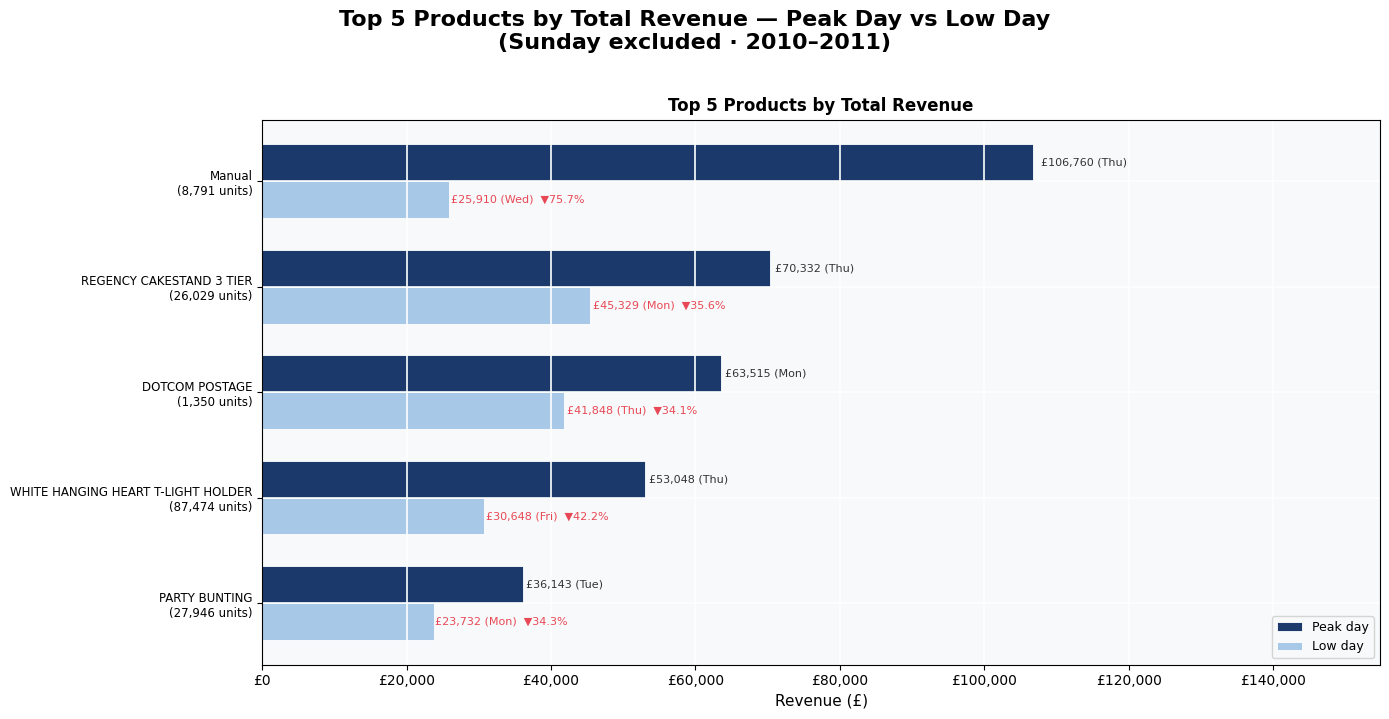

TOP 5 BY REVENUE:
                       Description   Revenue  Units Peak Day  Peak Revenue   Low Day  Low Revenue  Drop %
                            Manual 336565.80   8791 Thursday     106759.52 Wednesday     25909.95   75.70
          REGENCY CAKESTAND 3 TIER 324596.20  26029 Thursday      70331.98    Monday     45328.51   35.60
                    DOTCOM POSTAGE 271406.84   1350   Monday      63515.45  Thursday     41847.66   34.10
WHITE HANGING HEART T-LIGHT HOLDER 241527.85  87474 Thursday      53047.93    Friday     30647.95   42.20
                     PARTY BUNTING 146807.10  27946  Tuesday      36143.01    Monday     23732.24   34.30


In [ ]:
# POINT 2: TOP & BOTTOM PRODUCTS — Revenue (Sunday excluded)
# Sunday is excluded from peak/low calculation — already documented
# as a structural low. This isolates product-level variation.
# Bottom 5 excluded — products with 1–4 units sold across two years
# provide no analytical value for business decision-making.

df_2010_2011 = df_clean[df_clean['Year'].isin([2010, 2011])].copy()

product_summary = df_2010_2011.groupby('Description').agg(
    Revenue=('Revenue', 'sum'),
    Units=('Quantity', 'sum'),
    Transactions=('Invoice', 'nunique')
).reset_index()

day_product = df_2010_2011.groupby(
    ['Description', 'DayOfWeek']
)['Revenue'].sum().reset_index()

day_product_no_sun = day_product[day_product['DayOfWeek'] != 'Sunday']

peak_day = day_product_no_sun.loc[
    day_product_no_sun.groupby('Description')['Revenue'].idxmax()
][['Description','DayOfWeek','Revenue']].rename(
    columns={'DayOfWeek':'Peak Day', 'Revenue':'Peak Revenue'})

low_day = day_product_no_sun.loc[
    day_product_no_sun.groupby('Description')['Revenue'].idxmin()
][['Description','DayOfWeek','Revenue']].rename(
    columns={'DayOfWeek':'Low Day', 'Revenue':'Low Revenue'})

product_summary = product_summary.merge(peak_day, on='Description')
product_summary = product_summary.merge(low_day, on='Description')
product_summary['Drop %'] = (
    (product_summary['Peak Revenue'] - product_summary['Low Revenue'])
    / product_summary['Peak Revenue'] * 100
).round(1)

top5_rev   = product_summary.nlargest(5, 'Revenue').copy()
top5_units = product_summary.nlargest(5, 'Units').copy()
bot5_units = product_summary.nsmallest(5, 'Units').copy()

def plot_peak_vs_low(ax, data, title, color_peak, color_low):
    data = data.sort_values('Revenue', ascending=True).reset_index(drop=True)
    y = range(len(data))
    height = 0.35

    bars_peak = ax.barh(
        [i + height/2 for i in y],
        data['Peak Revenue'],
        height=height,
        color=color_peak,
        edgecolor='white',
        linewidth=0.6,
        label='Peak day'
    )
    bars_low = ax.barh(
        [i - height/2 for i in y],
        data['Low Revenue'],
        height=height,
        color=color_low,
        edgecolor='white',
        linewidth=0.6,
        label='Low day'
    )

    ax.set_yticks(list(y))
    ax.set_yticklabels(
        [f"{row['Description'][:35]}\n({row['Units']:,} units)"
         for _, row in data.iterrows()],
        fontsize=8.5
    )

    for bar, (_, row) in zip(bars_peak, data.iterrows()):
        ax.text(bar.get_width() + bar.get_width()*0.01,
                bar.get_y() + bar.get_height()/2,
                f"£{row['Peak Revenue']:,.0f} ({row['Peak Day'][:3]})",
                va='center', fontsize=8, color=PALETTE['text'])

    for bar, (_, row) in zip(bars_low, data.iterrows()):
        ax.text(bar.get_width() + bar.get_width()*0.01,
                bar.get_y() + bar.get_height()/2,
                f"£{row['Low Revenue']:,.0f} ({row['Low Day'][:3]})  ▼{row['Drop %']}%",
                va='center', fontsize=8, color=PALETTE['accent'])

    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Revenue (£)')
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))
    ax.set_xlim(0, data['Peak Revenue'].max() * 1.45)
    ax.legend(fontsize=9, loc='lower right')

fig, ax = plt.subplots(figsize=(14, 7))
fig.suptitle('Top 5 Products by Total Revenue — Peak Day vs Low Day\n(Sunday excluded · 2010–2011)', y=1.02)

plot_peak_vs_low(ax, top5_rev,
    'Top 5 Products by Total Revenue',
    PALETTE['primary'], PALETTE['neutral'])

plt.tight_layout()
plt.savefig('product_revenue_top5.png', dpi=150, bbox_inches='tight')
plt.show()

print("TOP 5 BY REVENUE:")
print(top5_rev[['Description','Revenue','Units','Peak Day',
                'Peak Revenue','Low Day','Low Revenue','Drop %']].to_string(index=False))

### What the Top 5 Revenue chart shows

**Thursday emerges as the dominant revenue day at the product level.**
Four out of five top-revenue products peak on either Thursday or Tuesday —
and this is not a coincidence isolated to this chart.

Looking back at the weekly pattern analysis:
- 2010 H1 peak day: Thursday
- 2011 H2 peak day: Thursday

Thursday consistently carries the highest revenue weight across different
time periods and at the individual product level. This suggests Thursday
is not just a high-traffic day — it's a high-value day. The distinction
matters: more transactions would indicate more customers, but higher revenue
per day could indicate larger order sizes from the same wholesale buyers.

**We'll investigate whether Thursday's dominance reflects order volume
or order size at the monthly analysis level.**

A second pattern worth noting is the drop between peak and low day.
Manual entries show a 75.7% collapse on their worst day — the largest
drop in the top 5. Every other product stays within a 34–42% range,
which is relatively stable for a wholesale retailer. This suggests
that outside of administrative entries, the top revenue products
maintain consistent performance across active trading days.

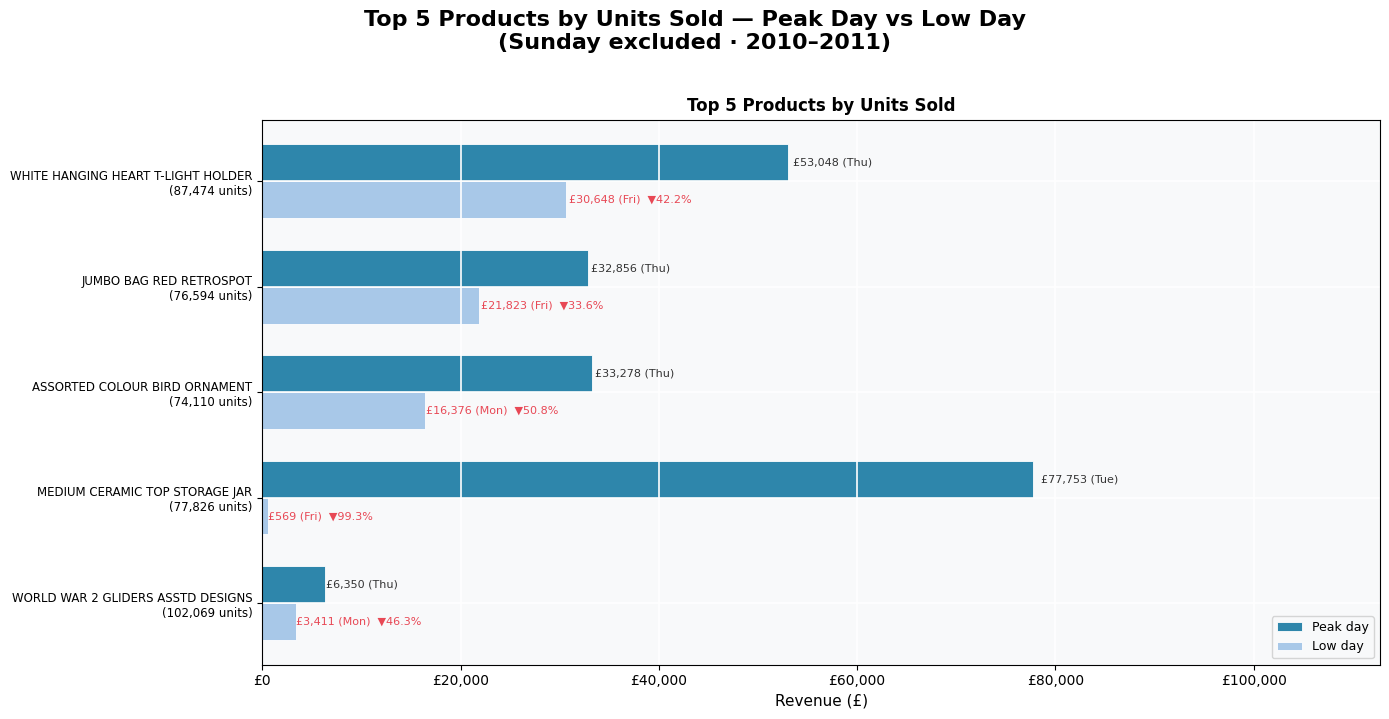

TOP 5 BY UNITS:
                       Description   Revenue  Units Peak Day  Peak Revenue Low Day  Low Revenue  Drop %
 WORLD WAR 2 GLIDERS ASSTD DESIGNS  23516.09 102069 Thursday       6350.49  Monday      3411.35   46.30
WHITE HANGING HEART T-LIGHT HOLDER 241527.85  87474 Thursday      53047.93  Friday     30647.95   42.20
    MEDIUM CERAMIC TOP STORAGE JAR  81448.21  77826  Tuesday      77752.60  Friday       568.76   99.30
           JUMBO BAG RED RETROSPOT 145846.57  76594 Thursday      32856.19  Friday     21823.48   33.60
     ASSORTED COLOUR BIRD ORNAMENT 119537.82  74110 Thursday      33278.06  Monday     16375.73   50.80


In [ ]:
# Bottom 5 excluded from both metrics —
# products with 1 unit sold across two years provide no analytical value.
# They neither sustain revenue nor represent meaningful stock movement.
# Analysis focuses on top performers only.

fig, ax = plt.subplots(figsize=(14, 7))
fig.suptitle('Top 5 Products by Units Sold — Peak Day vs Low Day\n(Sunday excluded · 2010–2011)', y=1.02)

plot_peak_vs_low(ax, top5_units,
    'Top 5 Products by Units Sold',
    PALETTE['secondary'], PALETTE['neutral'])

plt.tight_layout()
plt.savefig('product_units_top5.png', dpi=150, bbox_inches='tight')
plt.show()

print("TOP 5 BY UNITS:")
print(top5_units[['Description','Revenue','Units','Peak Day',
                  'Peak Revenue','Low Day','Low Revenue','Drop %']].to_string(index=False))

### What the Top 5 Units chart shows

**Thursday's dominance extends to volume — not just revenue.**
Four out of five top-selling products by units peak on Thursday,
confirming that Thursday's revenue strength is driven by higher
transaction volume, not larger individual order sizes.
Both metrics tell the same story: Thursday is structurally the
most active trading day for this business.

**Friday and Monday appear frequently as low-volume days,
but this cannot yet be declared a pattern.**
With only 5 products, one exception is enough to break the rule —
and we have one in each chart. This is worth revisiting at the
monthly level where we'll have more data points to either
confirm or reject this observation.

**The most notable finding is the MEDIUM CERAMIC TOP STORAGE JAR.**
102,069 units sold — the highest volume product — but only £23,516
in total revenue. Compare that to WHITE HANGING HEART T-LIGHT HOLDER:
87,474 units, £241,527 revenue. Nearly the same volume, ten times
the revenue. This is the clearest example in the dataset of high
volume not guaranteeing high value — and it validates the decision
to analyze both metrics separately.

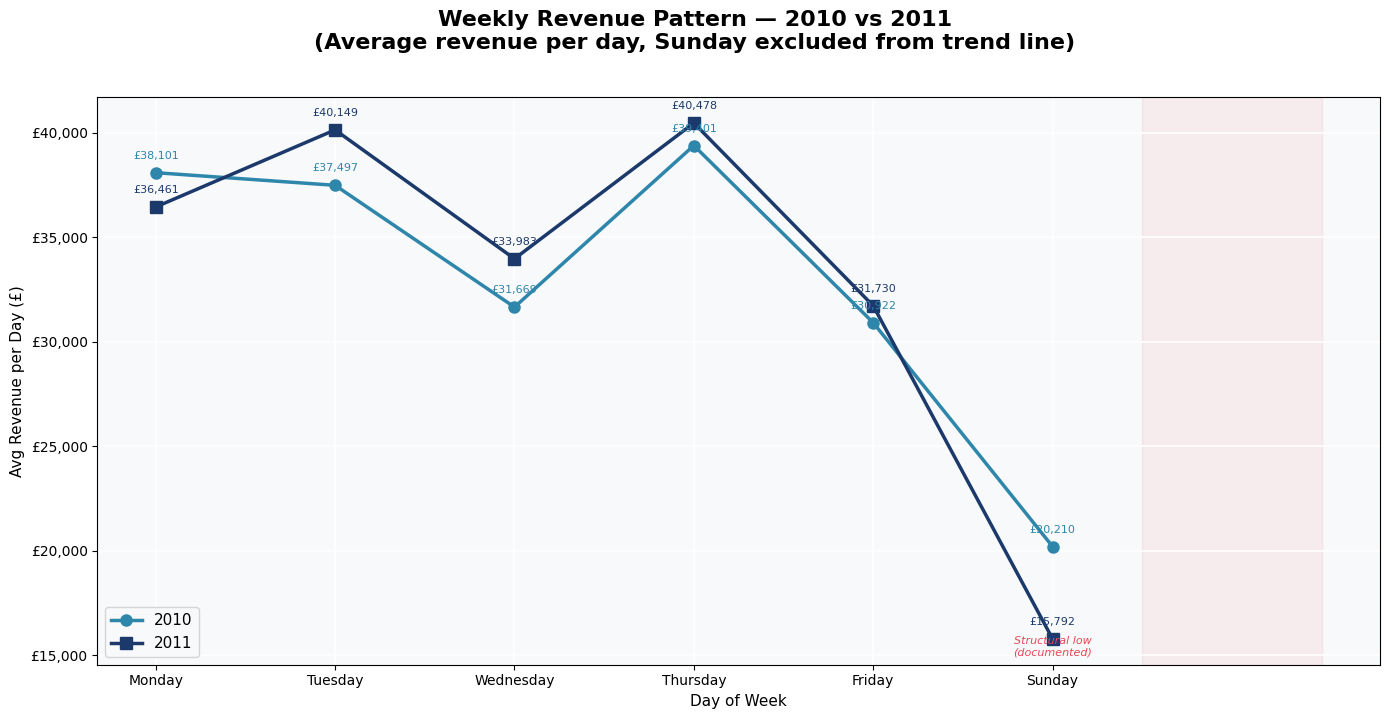


2010 vs 2011 — Weekly Pattern Comparison:
Year          2010     2011   Diff £  Diff %
DayOfWeek                                   
Monday    38100.67 36461.13 -1639.54   -4.30
Tuesday   37496.94 40148.76  2651.82    7.10
Wednesday 31669.28 33982.55  2313.27    7.30
Thursday  39400.77 40478.48  1077.71    2.70
Friday    30921.99 31729.67   807.68    2.60
Sunday    20209.70 15791.58 -4418.12  -21.90


In [ ]:
#  POINT 3: WEEKLY PATTERN COMPARISON — 2010 vs 2011
# Do both years follow the same weekly rhythm?
# We use average daily revenue per week to normalize for the
# different number of weeks in each year's dataset.

day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Sunday']

weekly_yearly = df_clean[df_clean['Year'].isin([2010, 2011])].groupby(
    ['Year', 'DayOfWeek', df_clean[df_clean['Year'].isin([2010,2011])]['InvoiceDate'].dt.isocalendar().week]
)['Revenue'].sum().reset_index()

weekly_yearly = weekly_yearly.groupby(
    ['Year','DayOfWeek']
)['Revenue'].mean().reset_index()

weekly_yearly['DayOfWeek'] = pd.Categorical(
    weekly_yearly['DayOfWeek'], categories=day_order, ordered=True)
weekly_yearly = weekly_yearly.sort_values(['Year','DayOfWeek'])

# PLOT
fig, ax = plt.subplots(figsize=(14, 7))
fig.suptitle('Weekly Revenue Pattern — 2010 vs 2011\n(Average revenue per day, Sunday excluded from trend line)', y=1.02)

for year, color, marker in [
    (2010, PALETTE['secondary'], 'o'),
    (2011, PALETTE['primary'],   's')
]:
    data = weekly_yearly[weekly_yearly['Year'] == year]
    ax.plot(
        data['DayOfWeek'].astype(str),
        data['Revenue'],
        color=color,
        marker=marker,
        linewidth=2.5,
        markersize=8,
        label=str(year)
    )
    # Value labels
    for _, row in data.iterrows():
        ax.annotate(
            f"£{row['Revenue']:,.0f}",
            xy=(row['DayOfWeek'], row['Revenue']),
            xytext=(0, 10),
            textcoords='offset points',
            ha='center', fontsize=8,
            color=color
        )

ax.set_xlabel('Day of Week')
ax.set_ylabel('Avg Revenue per Day (£)')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))
ax.legend(fontsize=11)

# Highlight Sunday as structural low
ax.axvspan(5.5, 6.5, alpha=0.08, color=PALETTE['accent'], label='Sunday (structural low)')
ax.annotate('Structural low\n(documented)', xy=(5, weekly_yearly['Revenue'].min() * 0.95),
            ha='center', fontsize=8, color=PALETTE['accent'], style='italic')

plt.tight_layout()
plt.savefig('weekly_pattern_2010_vs_2011.png', dpi=150, bbox_inches='tight')
plt.show()

# Numeric comparison
pivot = weekly_yearly.pivot(index='DayOfWeek', columns='Year', values='Revenue').round(2)
pivot['Diff £'] = (pivot[2011] - pivot[2010]).round(2)
pivot['Diff %'] = ((pivot[2011] - pivot[2010]) / pivot[2010] * 100).round(1)
print("\n2010 vs 2011 — Weekly Pattern Comparison:")
print(pivot.to_string())

### 2010 vs 2011 — Does the weekly pattern hold?

**Yes — and the shape of the week is remarkably consistent across both years.**
The line chart shows two curves that follow nearly identical trajectories:
a rise toward Thursday, a mid-week dip on Wednesday, and a sharp
collapse into Sunday.

This consistency across two consecutive years confirms that the
weekly rhythm is not random variation — it is a structural behavioral
pattern of this business and its customer base.

**The business grew — and it grew evenly across the week.**
Every weekday shows positive revenue growth from 2010 to 2011
(between +2.6% and +7.3%), with no single day driving the growth
disproportionately. This suggests organic, balanced growth rather
than a spike in one specific segment.

**Wednesday is the structural mid-week low — not Monday or Friday.**
Earlier we noted that Monday and Friday appeared frequently as low days
at the product level, but the year-level comparison corrects that reading.
Wednesday consistently underperforms both the days before and after it
in both years. This is the real mid-week valley.

**One exception worth noting: Monday 2011 dropped -4.3% vs 2010**,
the only weekday to show negative growth year-over-year.
This is an isolated signal — not enough to declare a trend,
but worth monitoring if a third year of data were available.

**Sunday's decline deepened: -21.9% from 2010 to 2011.**
While every other day grew, Sunday contracted significantly.
Combined with the H1/H2 analysis showing Sunday's drop widening
over time, this reinforces the pattern: Sunday is not just low —
it is progressively losing relevance as a trading day for this business.

### 5.4 Country Dominance — Who drives the revenue?

Before comparing countries across days, we need to address a structural
imbalance in the data. The pie chart below makes the case visually —
and justifies every country chart that follows.

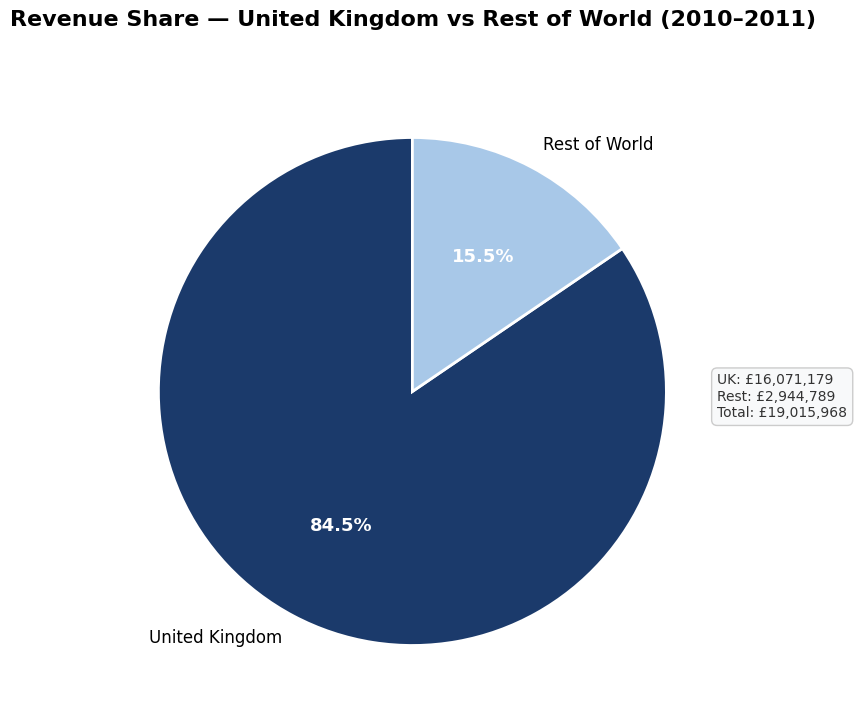

UK share: 84.5%  |  Rest of World: 15.5%


In [ ]:
#  COUNTRY ANALYSIS — Step 1: UK vs Rest of World
df_countries = df_clean[df_clean['Year'].isin([2010, 2011])].copy()

country_revenue = df_countries.groupby('Country')['Revenue'].sum().reset_index()
country_revenue = country_revenue.sort_values('Revenue', ascending=False)

uk_revenue  = country_revenue[country_revenue['Country'] == 'United Kingdom']['Revenue'].values[0]
rest_revenue = country_revenue[country_revenue['Country'] != 'United Kingdom']['Revenue'].sum()
total_revenue = country_revenue['Revenue'].sum()

uk_pct   = uk_revenue / total_revenue * 100
rest_pct = rest_revenue / total_revenue * 100

fig, ax = plt.subplots(figsize=(10, 7))
fig.suptitle('Revenue Share — United Kingdom vs Rest of World (2010–2011)', y=1.02)

wedges, texts, autotexts = ax.pie(
    [uk_revenue, rest_revenue],
    labels=['United Kingdom', 'Rest of World'],
    autopct='%1.1f%%',
    colors=[PALETTE['primary'], PALETTE['neutral']],
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2},
    textprops={'fontsize': 12}
)
for autotext in autotexts:
    autotext.set_fontsize(13)
    autotext.set_fontweight('bold')
    autotext.set_color('white')

ax.annotate(
    f'UK: £{uk_revenue:,.0f}\nRest: £{rest_revenue:,.0f}\nTotal: £{total_revenue:,.0f}',
    xy=(1.2, -0.1), fontsize=10, color=PALETTE['text'],
    bbox=dict(boxstyle='round,pad=0.4', facecolor='#F8F9FA', edgecolor='#CCCCCC')
)

plt.tight_layout()
plt.savefig('country_pie.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"UK share: {uk_pct:.1f}%  |  Rest of World: {rest_pct:.1f}%")

### 5.4 Country Dominance — The case for excluding UK

The pie chart below answers a simple question before we compare countries:
*is the playing field even enough to put everyone on the same chart?*

The answer is no.

United Kingdom accounts for **84.5% of all revenue** generated between 2010 and 2011 —
£16,071,179 out of a total £19,015,968. Every other country in the dataset,
combined, represents only 15.5% of the business.

This isn't a mild imbalance — it's a structural one.
Any chart that includes UK alongside other countries isn't showing
a comparison, it's showing UK and then everything else rendered invisible.

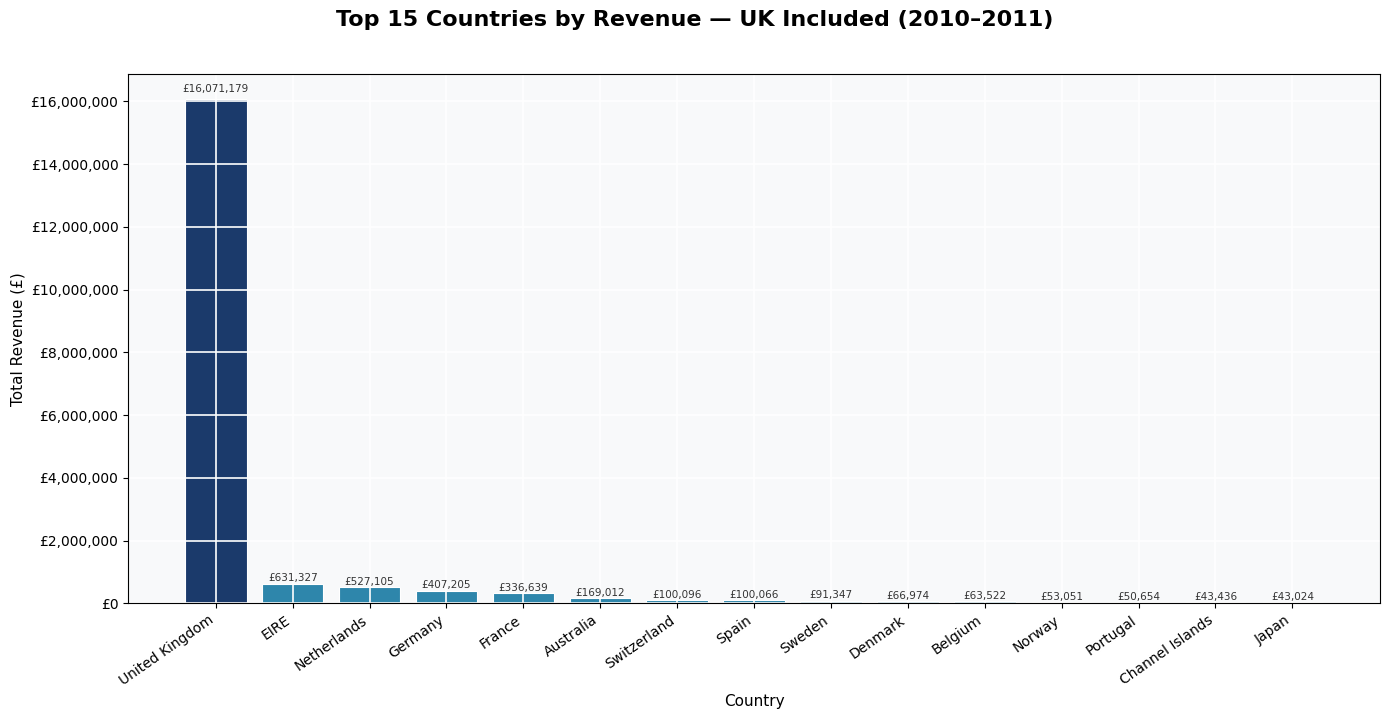

In [ ]:
#  COUNTRY ANALYSIS — Step 2: All countries, UK included
# UK's dominance makes other markets invisible — this chart exists
# solely to show that dominance before excluding UK in the next one.

top15 = country_revenue.head(15)

fig, ax = plt.subplots(figsize=(14, 7))
fig.suptitle('Top 15 Countries by Revenue — UK Included (2010–2011)', y=1.02)

bar_colors = [
    PALETTE['primary'] if c == 'United Kingdom'
    else PALETTE['secondary']
    for c in top15['Country']
]

bars = ax.bar(
    top15['Country'], top15['Revenue'],
    color=bar_colors, edgecolor='white', linewidth=0.8
)

for bar in bars:
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + bar.get_height()*0.01,
        f'£{bar.get_height():,.0f}',
        ha='center', va='bottom', fontsize=7.5, color=PALETTE['text']
    )

ax.set_xlabel('Country')
ax.set_ylabel('Total Revenue (£)')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))
plt.xticks(rotation=35, ha='right')
plt.tight_layout()
plt.savefig('country_with_uk.png', dpi=150, bbox_inches='tight')
plt.show()

### The visual consequence of including UK

The bar chart above makes the pie chart's point concrete.
Every country outside the UK — including EIRE (£631K), Netherlands (£527K),
and Germany (£407K) — is compressed into bars so small they
barely register on the same scale as UK's £16 million column.

Switzerland and Spain, both generating ~£100K, are virtually unreadable.
Japan, Channel Islands, and Portugal at the bottom are flat lines.

This is not a visualization problem — it's a data reality.
Including UK doesn't enrich the country comparison, it erases it.

**The next chart removes UK entirely.**
Not because UK is unimportant — it is clearly the backbone of this business —
but because the international markets deserve their own scale
to be understood on their own terms.

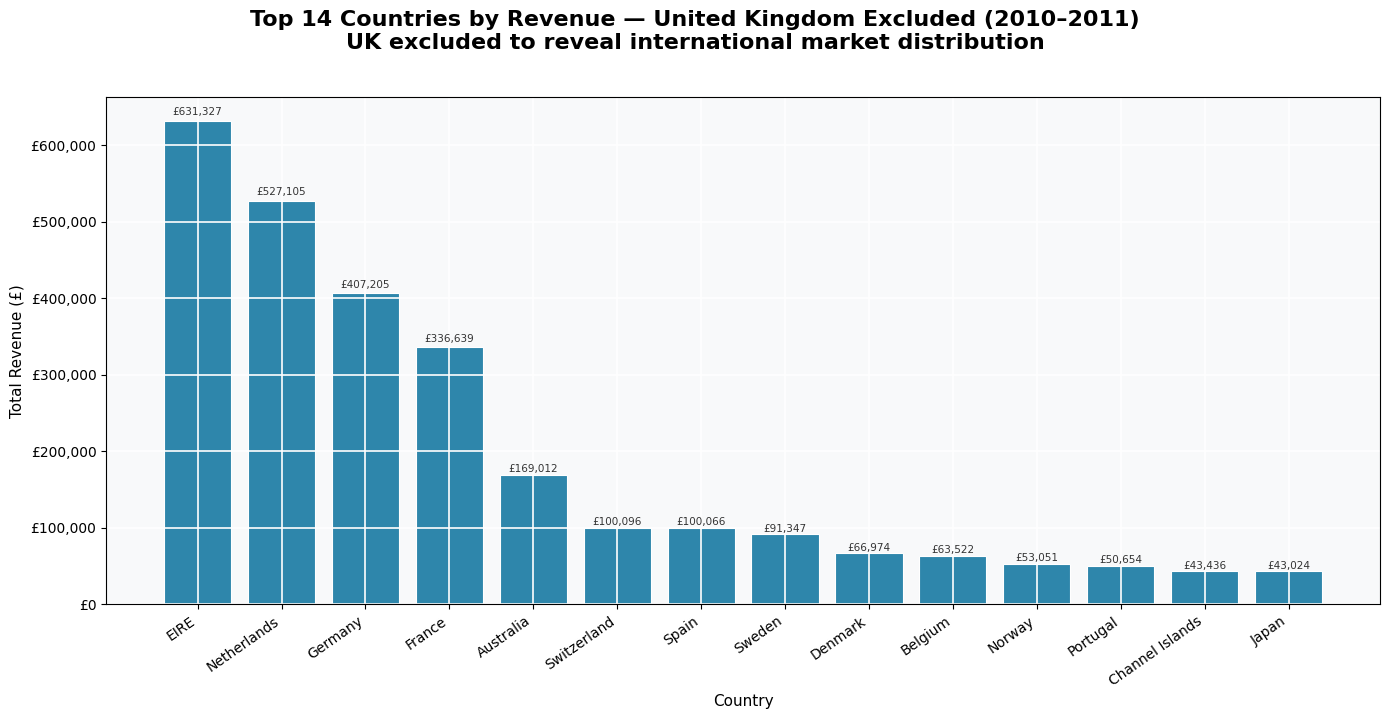


Top 10 countries by revenue (UK excluded):
    Country   Revenue
       EIRE 631326.68
Netherlands 527105.34
    Germany 407205.27
     France 336639.48
  Australia 169012.36
Switzerland 100096.19
      Spain 100066.10
     Sweden  91346.52
    Denmark  66974.13
    Belgium  63522.49


In [ ]:
# COUNTRY ANALYSIS — Step 3: UK excluded
# With UK removed, the international revenue distribution
# becomes readable and comparable across markets.

top14_no_uk = country_revenue[
    country_revenue['Country'] != 'United Kingdom'
].head(14)

fig, ax = plt.subplots(figsize=(14, 7))
fig.suptitle(
    'Top 14 Countries by Revenue — United Kingdom Excluded (2010–2011)\n'
    'UK excluded to reveal international market distribution', y=1.02
)

bars = ax.bar(
    top14_no_uk['Country'], top14_no_uk['Revenue'],
    color=PALETTE['secondary'], edgecolor='white', linewidth=0.8
)

for bar in bars:
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + bar.get_height()*0.01,
        f'£{bar.get_height():,.0f}',
        ha='center', va='bottom', fontsize=7.5, color=PALETTE['text']
    )

ax.set_xlabel('Country')
ax.set_ylabel('Total Revenue (£)')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))
plt.xticks(rotation=35, ha='right')
plt.tight_layout()
plt.savefig('country_no_uk.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 10 countries by revenue (UK excluded):")
print(top14_no_uk.head(10).to_string(index=False))

In [ ]:
# Validate the "top 5 sustain the international market" observation
top5_no_uk = top14_no_uk.head(5)
top5_revenue = top5_no_uk['Revenue'].sum()
intl_total = top14_no_uk['Revenue'].sum()
top5_pct = top5_revenue / intl_total * 100

australia_plus = top14_no_uk[top14_no_uk['Revenue'] <= 169012]['Revenue'].sum()
australia_plus_pct = australia_plus / intl_total * 100

print(f"Top 5 international (EIRE to France): £{top5_revenue:,.0f} — {top5_pct:.1f}% of intl revenue")
print(f"Australia onwards: £{australia_plus:,.0f} — {australia_plus_pct:.1f}% of intl revenue")
print(f"\nTop 5 share of TOTAL revenue (UK included): {top5_revenue/total_revenue*100:.1f}%")

Top 5 international (EIRE to France): £2,071,289 — 77.2% of intl revenue
Australia onwards: £612,170 — 22.8% of intl revenue

Top 5 share of TOTAL revenue (UK included): 10.9%


### What the international market actually looks like

Removing UK from the chart reveals a second concentration problem
within the international market itself.

**EIRE, Netherlands, Germany, France and Australia — the top 5 international
markets — account for 77.2% of all non-UK revenue (£2,071,289 out of £2,944,789).**
From Australia downward, the remaining 9 countries share only 22.8%
of international revenue between them — an average of roughly £68,000 each
across two full years of trading.

The "flat line" visible from Australia onwards in the chart is not a
visualization artifact — it reflects a real and sharp drop in commercial
relevance. Switzerland and Spain hover around £100K total.
Denmark, Belgium, Norway, Portugal, Channel Islands and Japan
each contribute between £43K and £67K over two years.

**Zooming out to the full picture including UK:**
The top 5 international markets combined represent only **10.9% of total revenue**.
UK alone represents 84.5%.

This means the business is overwhelmingly domestic —
with a thin but real international presence concentrated in
Western Europe, particularly in neighboring markets
(EIRE, Netherlands, Germany, France).

> *For a business looking to grow internationally,
> the data suggests that proximity to the UK —
> both geographic and cultural — correlates strongly
> with market penetration. Australia is the only
> non-European market with meaningful presence.*

## 6. Monthly Analysis

With the weekly patterns fully documented, we now zoom out to the monthly level.

This section follows the exact same structure as the weekly analysis:
peaks and low points, top products, year-over-year comparison,
and country dominance — all applied month by month.

The shift in scale is intentional. Weekly analysis reveals behavioral patterns
(which days drive revenue). Monthly analysis reveals seasonal patterns —
the rhythm of the business across the year, which periods are structurally
stronger, and whether that rhythm is consistent across both years.

**Scope:** January–November, 2010 and 2011.
December is excluded from the main analysis to preserve comparability
and will be examined separately at the end of this section.

In [ ]:
# MONTHLY ANALYSIS BASE
# Excluding December from both years for consistent month-to-month comparison.
# December will be analyzed separately as a standalone section.

df_monthly = df_clean[
    (df_clean['Year'].isin([2010, 2011])) &
    (df_clean['Month'] != 12)
].copy()

month_names = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
               7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov'}
df_monthly['MonthName'] = df_monthly['Month'].map(month_names)
month_order = list(month_names.values())

print(f"Monthly analysis dataset: {df_monthly.shape[0]:,} rows")
print(f"Period: {df_monthly['InvoiceDate'].min().date()} → {df_monthly['InvoiceDate'].max().date()}")
print(f"Months covered: {sorted(df_monthly['Month'].unique())}")

Monthly analysis dataset: 898,635 rows
Period: 2010-01-04 → 2011-11-30
Months covered: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11)]


### 6.1 Monthly Revenue Peaks and Low Points

Which months generate the most and least revenue?
Is there a consistent seasonal rhythm across both years?

We use total revenue per month to capture the full commercial weight
of each period — then compare the two years side by side to identify
whether the pattern is structural or varies year to year.

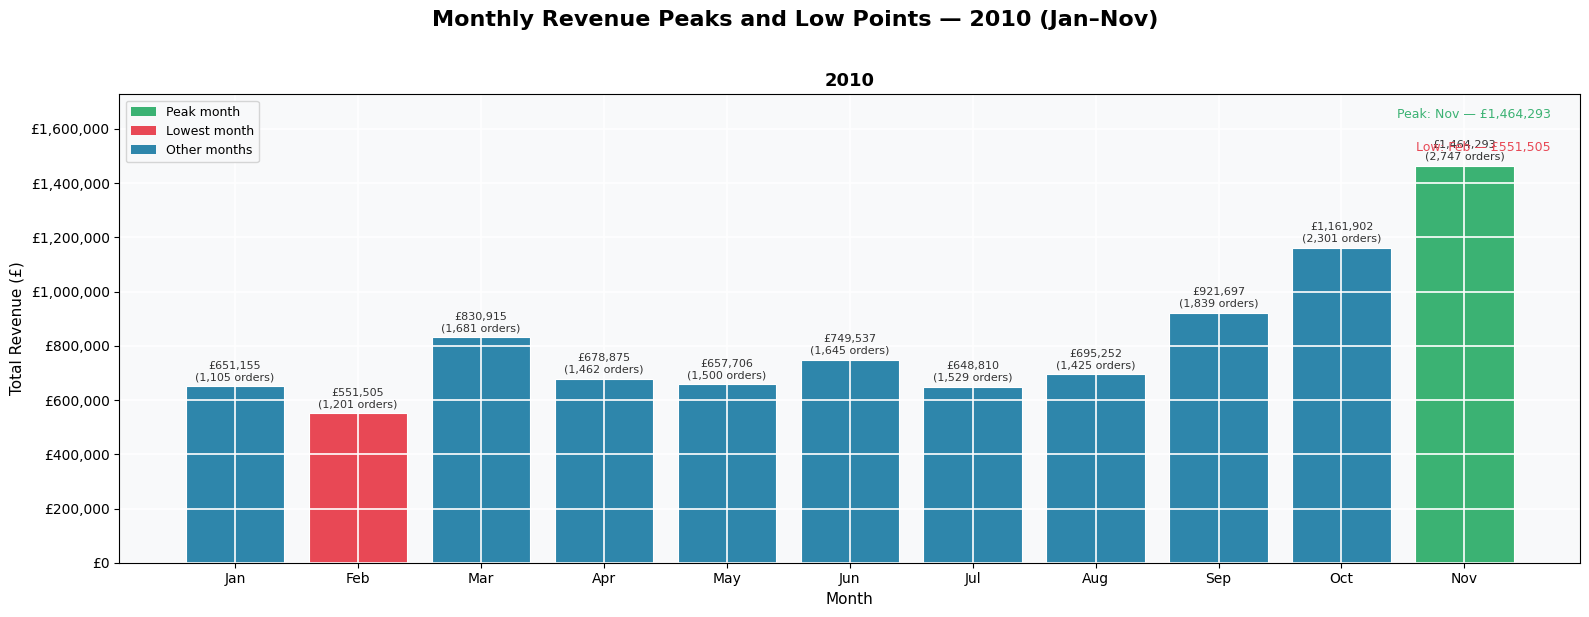

In [ ]:
# MONTHLY PEAKS — 2010
monthly_rev = df_monthly.groupby(['Year','Month','MonthName']).agg(
    Revenue=('Revenue','sum'),
    Transactions=('Invoice','nunique')
).reset_index()

monthly_rev['MonthName'] = pd.Categorical(
    monthly_rev['MonthName'], categories=month_order, ordered=True)
monthly_rev = monthly_rev.sort_values(['Year','Month'])

def plot_monthly_year(ax, year, data):
    group = data[data['Year'] == year].sort_values('Month')
    bar_colors = [
        PALETTE['positive'] if r == group['Revenue'].max()
        else PALETTE['accent'] if r == group['Revenue'].min()
        else PALETTE['secondary'] if year == 2010
        else PALETTE['primary']
        for r in group['Revenue']
    ]
    bars = ax.bar(
        group['MonthName'].astype(str),
        group['Revenue'],
        color=bar_colors,
        edgecolor='white',
        linewidth=0.8
    )
    max_val = group['Revenue'].max()
    for bar, (_, row) in zip(bars, group.iterrows()):
        ax.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + max_val*0.01,
            f"£{bar.get_height():,.0f}\n({row['Transactions']:,} orders)",
            ha='center', va='bottom', fontsize=8, color=PALETTE['text']
        )
    ax.set_title(str(year), fontsize=13)
    ax.set_xlabel('Month')
    ax.set_ylabel('Total Revenue (£)')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))
    ax.set_ylim(0, max_val * 1.18)
    peak = group.loc[group['Revenue'].idxmax()]
    low  = group.loc[group['Revenue'].idxmin()]
    ax.annotate(f"Peak: {peak['MonthName']} — £{peak['Revenue']:,.0f}",
                xy=(0.98, 0.95), xycoords='axes fraction',
                ha='right', fontsize=9, color=PALETTE['positive'])
    ax.annotate(f"Low: {low['MonthName']} — £{low['Revenue']:,.0f}",
                xy=(0.98, 0.88), xycoords='axes fraction',
                ha='right', fontsize=9, color=PALETTE['accent'])

fig, ax = plt.subplots(figsize=(16, 6))
fig.suptitle('Monthly Revenue Peaks and Low Points — 2010 (Jan–Nov)', y=1.02)
plot_monthly_year(ax, 2010, monthly_rev)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=PALETTE['positive'], label='Peak month'),
    Patch(facecolor=PALETTE['accent'],   label='Lowest month'),
    Patch(facecolor=PALETTE['secondary'],label='Other months'),
]
ax.legend(handles=legend_elements, fontsize=9, loc='upper left')
plt.tight_layout()
plt.savefig('monthly_peaks_2010.png', dpi=150, bbox_inches='tight')
plt.show()

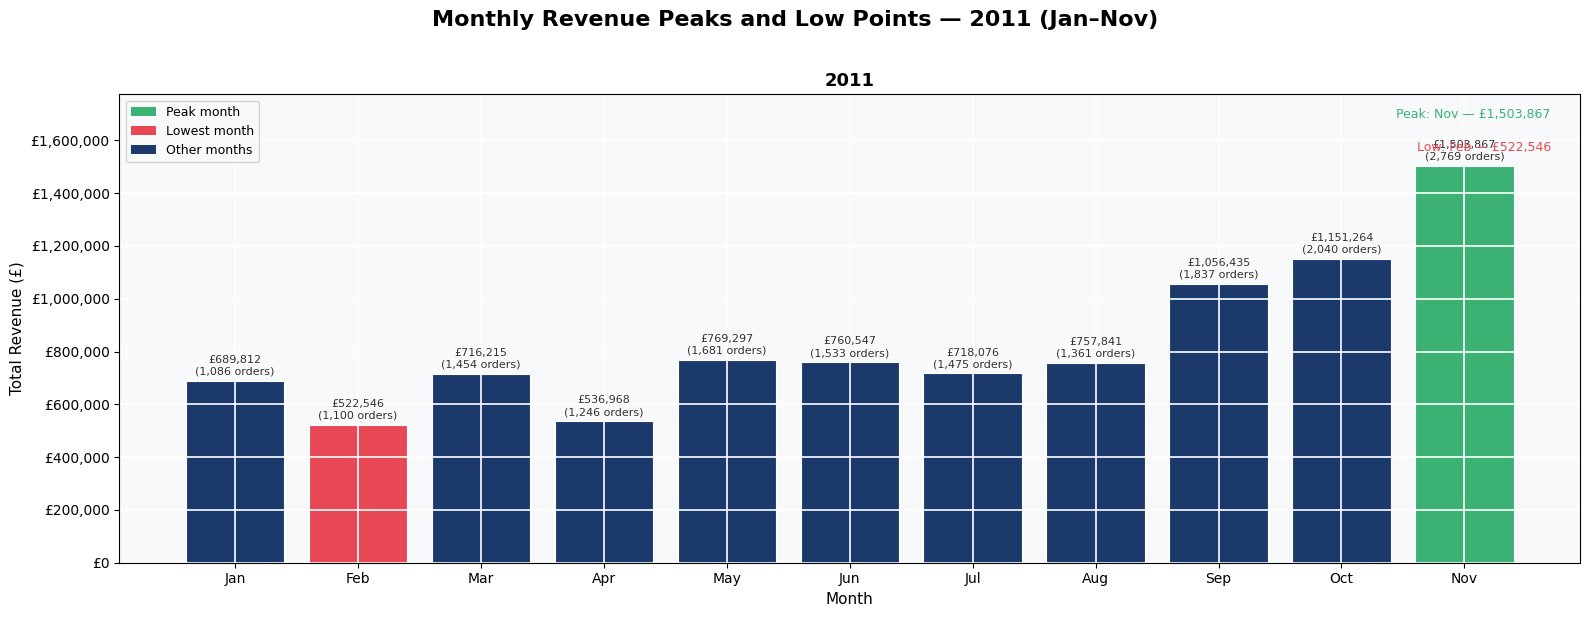

In [ ]:
# MONTHLY PEAKS — 2011
fig.suptitle('Monthly Revenue Peaks and Low Points — 2011 (Jan–Nov)', y=1.02)
plot_monthly_year(ax, 2011, monthly_rev)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=PALETTE['positive'], label='Peak month'),
    Patch(facecolor=PALETTE['accent'],   label='Lowest month'),
    Patch(facecolor=PALETTE['primary'],  label='Other months'),
]
ax.legend(handles=legend_elements, fontsize=9, loc='upper left')
plt.tight_layout()
plt.savefig('monthly_peaks_2011.png', dpi=150, bbox_inches='tight')
plt.show()

### What the monthly charts show — 2010 & 2011

**Both years follow an identical seasonal structure.**

The business starts January at a moderate level, drops in February
(the consistent low point of the year in both 2010 and 2011),
recovers in March above January's level, then plateaus across
April through August with relatively stable and comparable figures.

From September onward, revenue climbs steadily and accelerates
through October and November — which is the peak month in both years.

This creates a clear and repeatable annual shape:

> **Moderate start → February dip → Spring recovery →
> Summer plateau → Q4 acceleration → November peak**

The consistency across two consecutive years suggests this is not
random variation — it is the structural seasonal rhythm of this business.

**February is the only month that behaves as a structural low.**
Just as Sunday was the structural low at the weekly level,
February plays that role at the monthly level — in both years,
without exception.

**The Q4 acceleration (Sep–Nov) is the most commercially significant pattern.**
In 2010, revenue grows from £695K in August to £1,464K in November —
a 110% increase in three months.
In 2011, the same trajectory: from £757K in August to £1,503K in November —
a 98% increase over the same period.

**What happens in December remains an open question.**
Does the business continue climbing past November's peak,
or does it pull back to set up January's moderate start?
We'll investigate this in the standalone December analysis
at the end of this section.

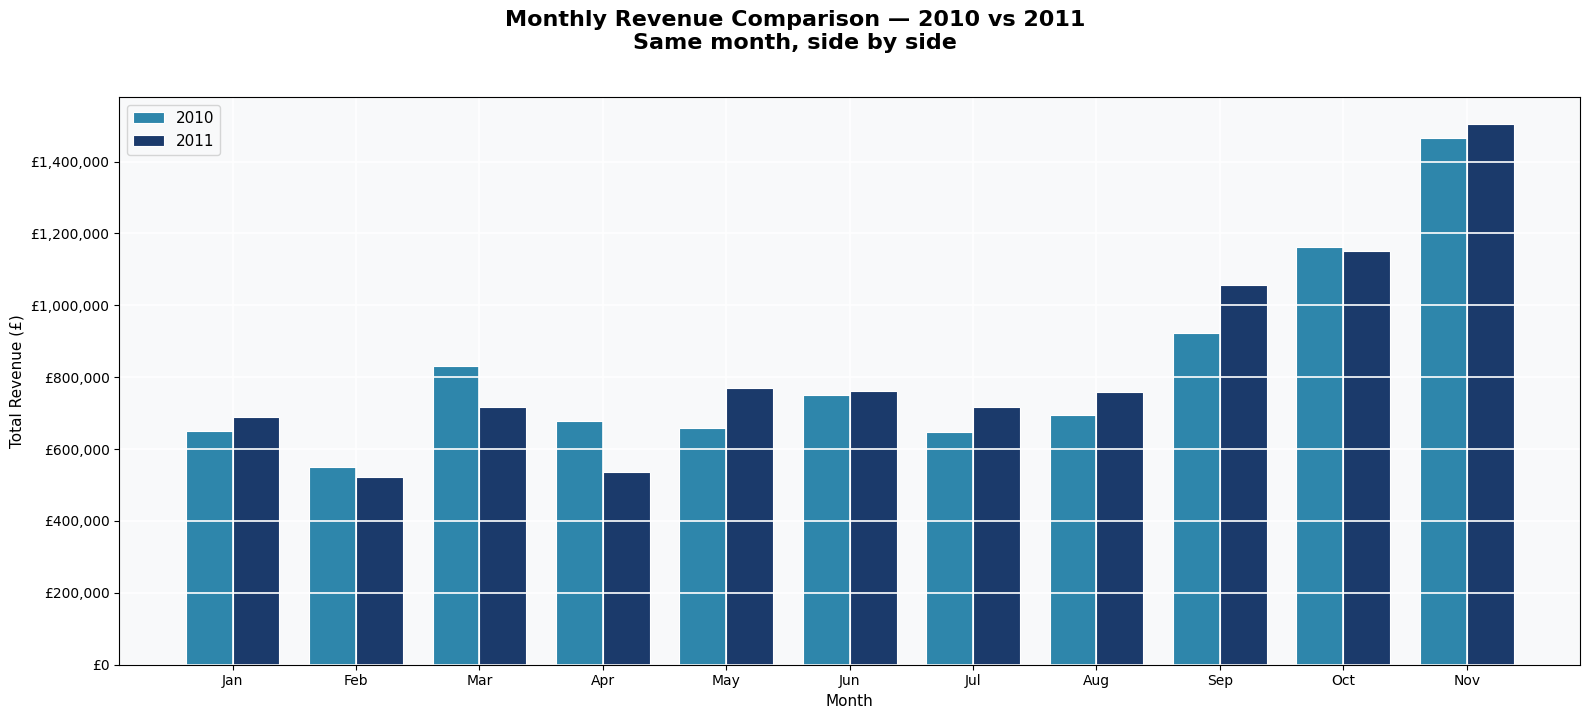


Monthly Revenue Comparison:
Year            2010       2011     Diff £  Diff %
MonthName                                         
Jan        651155.11  689811.61   38656.50    5.90
Feb        551504.73  522545.56  -28959.17   -5.30
Mar        830915.26  716215.26 -114700.00  -13.80
Apr        678875.25  536968.49 -141906.76  -20.90
May        657705.50  769296.61  111591.11   17.00
Jun        749537.31  760547.01   11009.70    1.50
Jul        648810.27  718076.12   69265.85   10.70
Aug        695251.91  757841.38   62589.47    9.00
Sep        921696.99 1056435.19  134738.20   14.60
Oct       1161902.22 1151263.73  -10638.49   -0.90
Nov       1464293.14 1503866.78   39573.64    2.70


In [ ]:
#  MONTHLY COMPARISON — 2010 vs 2011
# Grouped bars: one pair per month, color = year
# Direct visual comparison of which year was stronger each month

fig, ax = plt.subplots(figsize=(16, 7))
fig.suptitle('Monthly Revenue Comparison — 2010 vs 2011\nSame month, side by side', y=1.02)

months = month_order
x = range(len(months))
width = 0.38

data_2010 = monthly_rev[monthly_rev['Year'] == 2010].sort_values('Month')
data_2011 = monthly_rev[monthly_rev['Year'] == 2011].sort_values('Month')

bars_2010 = ax.bar(
    [i - width/2 for i in x],
    data_2010['Revenue'],
    width=width,
    color=PALETTE['secondary'],
    edgecolor='white',
    linewidth=0.8,
    label='2010'
)
bars_2011 = ax.bar(
    [i + width/2 for i in x],
    data_2011['Revenue'],
    width=width,
    color=PALETTE['primary'],
    edgecolor='white',
    linewidth=0.8,
    label='2011'
)

ax.set_xticks(list(x))
ax.set_xticklabels(months)
ax.set_xlabel('Month')
ax.set_ylabel('Total Revenue (£)')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))
ax.legend(fontsize=11)
plt.tight_layout()
plt.savefig('monthly_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Numeric table
pivot = monthly_rev.pivot_table(
    index='MonthName', columns='Year', values='Revenue'
).round(2)
pivot.index = pd.CategoricalIndex(pivot.index, categories=month_order, ordered=True)
pivot = pivot.sort_index()
pivot['Diff £'] = (pivot[2011] - pivot[2010]).round(2)
pivot['Diff %'] = ((pivot[2011] - pivot[2010]) / pivot[2010] * 100).round(1)
print("\nMonthly Revenue Comparison:")
print(pivot.to_string())

### 2010 vs 2011 — Monthly comparison

At first glance the chart shows two years following the same seasonal shape —
which confirms the structural pattern documented above.
But splitting the year in two reveals something more precise.

**H1 (January–May): 2010 outperformed 2011.**
March and April show the largest gaps: -13.8% and -20.9% respectively.
February, already the structural low of both years, dropped a further -5.3%.
The first half of 2011 was consistently weaker than the same period in 2010.

**H2 (June–November): 2011 outperformed 2010 in every single month.**
September shows the largest gain (+14.6%), followed by July (+10.7%)
and August (+9.0%). November, the peak month in both years,
grew a further +2.7% on top of an already strong 2010 base.
October is the only near-exception at -0.9% — effectively a draw.

**What this confirms:**
2011 was not uniformly a better year — it had a weaker first half.
But its second half was stronger across every month without exception,
and that's what drove the overall growth.

This is consistent with what we observed at the weekly level:
the H1 vs H2 gap widened in 2011, and the second half
carried disproportionately more commercial weight.

> *The business didn't just grow in 2011 — it grew in the right half
> of the year, compounding on the period that was already its strongest.*

In [23]:
# MONTHLY ANALYSIS — Point 2: Top products
# February excluded from peak/low calculation — structural low,
# already documented. Same reasoning as Sunday at weekly level.

df_monthly_prod = df_monthly.copy()

product_monthly = df_monthly_prod.groupby('Description').agg(
    Revenue=('Revenue', 'sum'),
    Units=('Quantity', 'sum'),
    Transactions=('Invoice', 'nunique')
).reset_index()

# Revenue and units per product per month
month_product = df_monthly_prod.groupby(
    ['Description', 'Month', 'MonthName']
)['Revenue'].sum().reset_index()

units_month_product = df_monthly_prod.groupby(
    ['Description', 'Month', 'MonthName']
)['Quantity'].sum().reset_index()

# Exclude February
month_product_no_feb   = month_product[month_product['Month'] != 2]
units_month_no_feb     = units_month_product[units_month_product['Month'] != 2]

# Peak and low month by revenue
peak_month = month_product_no_feb.loc[
    month_product_no_feb.groupby('Description')['Revenue'].idxmax()
][['Description','MonthName','Revenue']].rename(
    columns={'MonthName':'Peak Month','Revenue':'Peak Rev'})

low_month = month_product_no_feb.loc[
    month_product_no_feb.groupby('Description')['Revenue'].idxmin()
][['Description','MonthName','Revenue']].rename(
    columns={'MonthName':'Low Month','Revenue':'Low Rev'})

product_monthly = product_monthly.merge(peak_month, on='Description')
product_monthly = product_monthly.merge(low_month, on='Description')
product_monthly['Drop %'] = (
    (product_monthly['Peak Rev'] - product_monthly['Low Rev'])
    / product_monthly['Peak Rev'] * 100
).round(1)

top5_rev   = product_monthly.nlargest(5, 'Revenue').copy()
top5_units = product_monthly.nlargest(5, 'Units').copy()

print("Top 5 by Revenue:")
print(top5_rev[['Description','Revenue','Units','Peak Month',
                'Peak Rev','Low Month','Low Rev','Drop %']].to_string(index=False))
print("\nTop 5 by Units:")
print(top5_units[['Description','Revenue','Units','Peak Month',
                  'Peak Rev','Low Month','Low Rev','Drop %']].to_string(index=False))

Top 5 by Revenue:
                       Description   Revenue  Units Peak Month  Peak Rev Low Month  Low Rev  Drop %
                            Manual 334085.54   8589        Oct  73927.05       Nov  6247.94   91.50
          REGENCY CAKESTAND 3 TIER 296901.44  23952        Nov  41810.66       Jan 12800.60   69.40
                    DOTCOM POSTAGE 246735.65   1296        Nov  52195.32       Apr 12321.53   76.40
WHITE HANGING HEART T-LIGHT HOLDER 230293.63  83604        Nov  32763.62       Jun 16535.99   49.50
                     PARTY BUNTING 145599.36  27709        May  28799.56       Jan  3869.01   86.60

Top 5 by Units:
                       Description   Revenue  Units Peak Month  Peak Rev Low Month  Low Rev  Drop %
 WORLD WAR 2 GLIDERS ASSTD DESIGNS  22341.96  96874        Nov   3416.36       Jan   672.88   80.30
WHITE HANGING HEART T-LIGHT HOLDER 230293.63  83604        Nov  32763.62       Jun 16535.99   49.50
    MEDIUM CERAMIC TOP STORAGE JAR  81448.21  77826        Jan  7

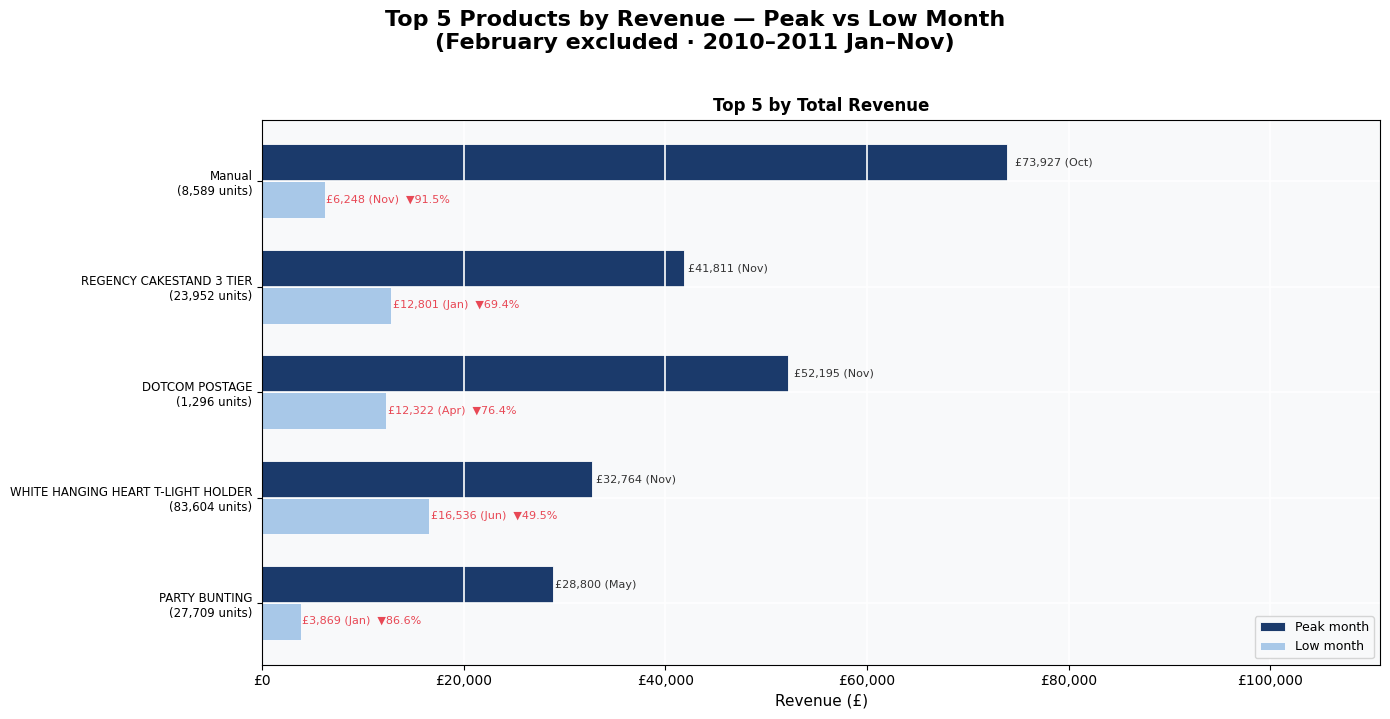

In [24]:
# ── TOP 5 BY REVENUE — Peak vs Low Month ─────────────────────────
def plot_monthly_peak_vs_low(ax, data, metric_peak, metric_low, title,
                              color_peak, color_low):
    data = data.sort_values('Revenue', ascending=True).reset_index(drop=True)
    y = range(len(data))
    height = 0.35

    bars_peak = ax.barh(
        [i + height/2 for i in y], data[metric_peak],
        height=height, color=color_peak,
        edgecolor='white', linewidth=0.6, label='Peak month'
    )
    bars_low = ax.barh(
        [i - height/2 for i in y], data[metric_low],
        height=height, color=color_low,
        edgecolor='white', linewidth=0.6, label='Low month'
    )

    ax.set_yticks(list(y))
    ax.set_yticklabels(
        [f"{row['Description'][:35]}\n({row['Units']:,} units)"
         for _, row in data.iterrows()],
        fontsize=8.5
    )

    for bar, (_, row) in zip(bars_peak, data.iterrows()):
        ax.text(bar.get_width() + bar.get_width()*0.01,
                bar.get_y() + bar.get_height()/2,
                f"£{row[metric_peak]:,.0f} ({row['Peak Month']})",
                va='center', fontsize=8, color=PALETTE['text'])

    for bar, (_, row) in zip(bars_low, data.iterrows()):
        ax.text(bar.get_width() + bar.get_width()*0.01,
                bar.get_y() + bar.get_height()/2,
                f"£{row[metric_low]:,.0f} ({row['Low Month']})  ▼{row['Drop %']}%",
                va='center', fontsize=8, color=PALETTE['accent'])

    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Revenue (£)')
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))
    ax.set_xlim(0, data[metric_peak].max() * 1.5)
    ax.legend(fontsize=9, loc='lower right')

fig, ax = plt.subplots(figsize=(14, 7))
fig.suptitle('Top 5 Products by Revenue — Peak vs Low Month\n'
             '(February excluded · 2010–2011 Jan–Nov)', y=1.02)

plot_monthly_peak_vs_low(ax, top5_rev, 'Peak Rev', 'Low Rev',
    'Top 5 by Total Revenue',
    PALETTE['primary'], PALETTE['neutral'])

plt.tight_layout()
plt.savefig('monthly_product_revenue_top5.png', dpi=150, bbox_inches='tight')
plt.show()

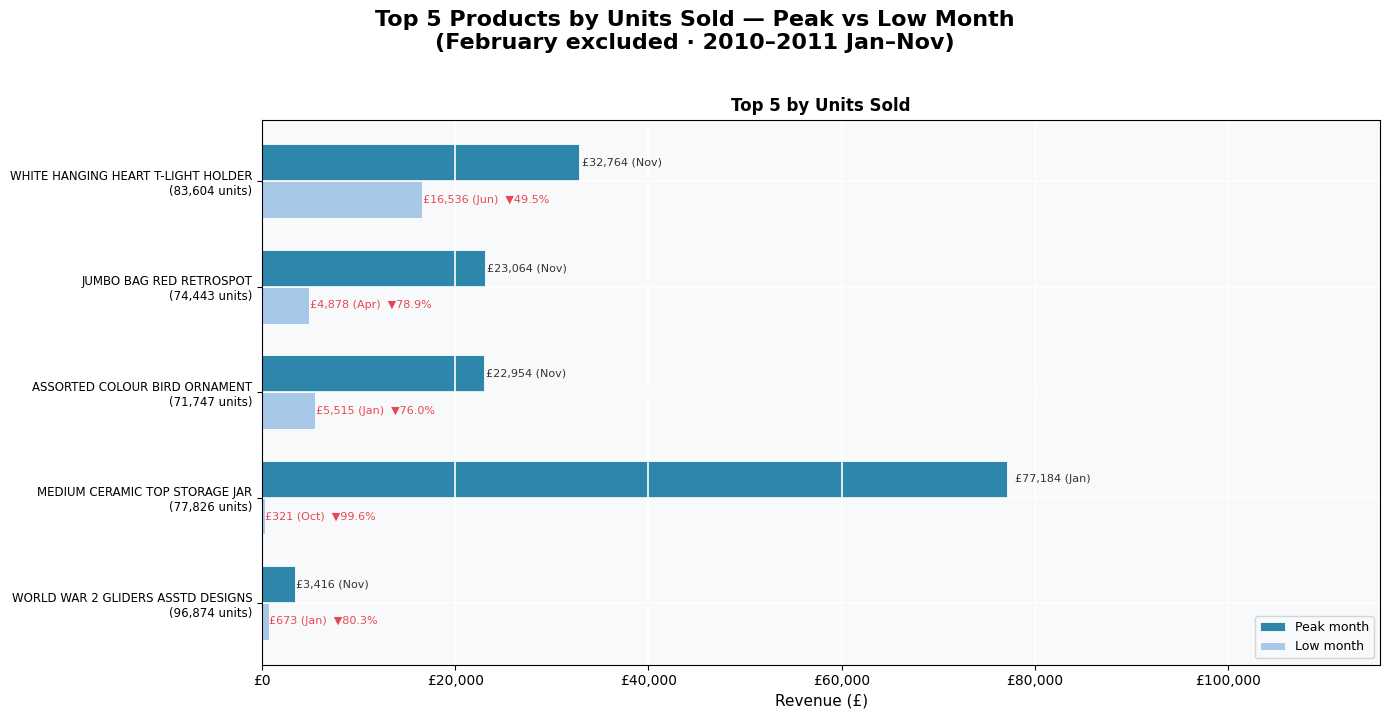

In [25]:
# TOP 5 BY UNITS — Peak vs Low Month
fig, ax = plt.subplots(figsize=(14, 7))
fig.suptitle('Top 5 Products by Units Sold — Peak vs Low Month\n'
             '(February excluded · 2010–2011 Jan–Nov)', y=1.02)

plot_monthly_peak_vs_low(ax, top5_units, 'Peak Rev', 'Low Rev',
    'Top 5 by Units Sold',
    PALETTE['secondary'], PALETTE['neutral'])

plt.tight_layout()
plt.savefig('monthly_product_units_top5.png', dpi=150, bbox_inches='tight')
plt.show()

### What the product charts show — monthly level

**The two charts tell completely different stories — and that's the finding.**

Unlike the weekly level where Thursday dominated both revenue and volume,
at the monthly level there is no single product that leads consistently
across both metrics. The top revenue products and the top volume products
are largely different, and their peak/low month profiles share no common shape.

**Variability is extreme at the individual product level.**
Drops between peak and low month range from 49.5% to 99.6% —
meaning some products nearly disappear in their worst month.
MEDIUM CERAMIC TOP STORAGE JAR goes from £77,184 in January
to £321 in October — a 99.6% collapse.
MANUAL entries swing from £73,927 in October to £6,248 in November — 91.5%.
These are not marginal fluctuations, they are structural on/off patterns.

**No two products share the same seasonal rhythm.**
Some peak in November, others in May or January.
Some bottom out in January, others in April, June or October.
There is no common monthly pattern at the product level.

**What this means for the business:**
The overall seasonal stability we identified — the consistent Jan–Nov curve —
is not carried by individual products behaving consistently.
It is the result of a large and diverse catalog where different products
peak at different times, collectively smoothing out the revenue curve.

> *The business's seasonal resilience comes from product diversity,
> not from individual product consistency.
> No single product sustains the numbers — the catalog does.*

### December Spotlight — Revenue vs Volume (2009 & 2010)

Before moving forward, a focused look at December.
We can't use it as a full comparative reference — 2009 has only one December
and 2011's December was excluded for being incomplete.
But we can ask one specific question:

**Does December's top revenue product match its top volume product?**
If yes, December follows the same pattern we've seen elsewhere.
If not, December has its own commercial logic —
which would be worth noting even without a full year of context.

TOP PRODUCT BY REVENUE — December:
 Year      Top Revenue Product  Revenue  Units
 2009           DOTCOM POSTAGE 18574.58     49
 2010 REGENCY CAKESTAND 3 TIER 27694.76   2077

TOP PRODUCT BY UNITS — December:
 Year                  Top Units Product  Revenue  Units
 2009 WHITE HANGING HEART T-LIGHT HOLDER 17255.35   6406
 2010  WORLD WAR 2 GLIDERS ASSTD DESIGNS  1174.13   5195


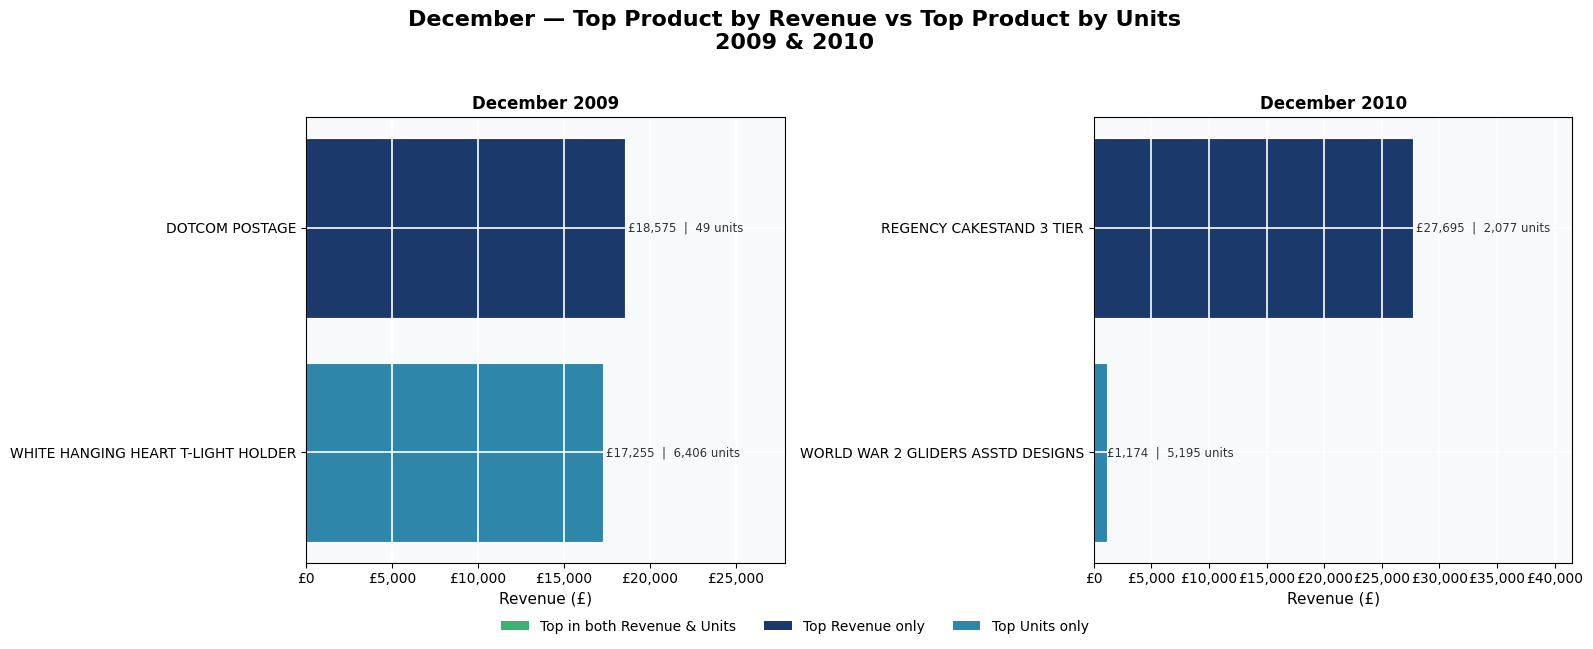

In [26]:
# DECEMBER — Top product by Revenue vs Units
# Limited to 2009 and 2010 — the only two complete Decembers available.
# Not used as a trend reference — used only to observe December's
# internal product behavior.

df_dec = df_clean[
    (df_clean['Month'] == 12) &
    (df_clean['Year'].isin([2009, 2010]))
].copy()

dec_products = df_dec.groupby(['Year','Description']).agg(
    Revenue=('Revenue','sum'),
    Units=('Quantity','sum')
).reset_index()

# Top 1 by revenue and units per year
top1_rev = dec_products.loc[
    dec_products.groupby('Year')['Revenue'].idxmax()
][['Year','Description','Revenue','Units']].rename(
    columns={'Description':'Top Revenue Product'})

top1_units = dec_products.loc[
    dec_products.groupby('Year')['Units'].idxmax()
][['Year','Description','Revenue','Units']].rename(
    columns={'Description':'Top Units Product'})

print("TOP PRODUCT BY REVENUE — December:")
print(top1_rev.to_string(index=False))
print("\nTOP PRODUCT BY UNITS — December:")
print(top1_units.to_string(index=False))

# PLOT
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('December — Top Product by Revenue vs Top Product by Units\n2009 & 2010', y=1.02)

for ax, (year, group) in zip(axes, dec_products.groupby('Year')):
    top_rev   = group.nlargest(1, 'Revenue')
    top_units = group.nlargest(1, 'Units')

    combined = pd.concat([top_rev, top_units]).drop_duplicates('Description')
    combined = combined.sort_values('Revenue', ascending=True)

    bar_colors = []
    for _, row in combined.iterrows():
        if row['Description'] == top_rev['Description'].values[0] and \
           row['Description'] == top_units['Description'].values[0]:
            bar_colors.append(PALETTE['positive'])   # same product — both metrics
        elif row['Description'] == top_rev['Description'].values[0]:
            bar_colors.append(PALETTE['primary'])    # top revenue only
        else:
            bar_colors.append(PALETTE['secondary'])  # top units only

    bars = ax.barh(
        combined['Description'].str[:35],
        combined['Revenue'],
        color=bar_colors,
        edgecolor='white',
        linewidth=0.8
    )

    for bar, (_, row) in zip(bars, combined.iterrows()):
        ax.text(
            bar.get_width() + bar.get_width()*0.01,
            bar.get_y() + bar.get_height()/2,
            f"£{row['Revenue']:,.0f}  |  {row['Units']:,} units",
            va='center', fontsize=8.5, color=PALETTE['text']
        )

    ax.set_title(f'December {year}', fontsize=12)
    ax.set_xlabel('Revenue (£)')
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))
    ax.set_xlim(0, combined['Revenue'].max() * 1.5)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=PALETTE['positive'],  label='Top in both Revenue & Units'),
    Patch(facecolor=PALETTE['primary'],   label='Top Revenue only'),
    Patch(facecolor=PALETTE['secondary'], label='Top Units only'),
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3,
           frameon=False, fontsize=10, bbox_to_anchor=(0.5, -0.04))

plt.tight_layout()
plt.savefig('december_top_products.png', dpi=150, bbox_inches='tight')
plt.show()

### December Pattern — Daily Revenue Distribution

Rather than leaving December as an open question,
we examine the daily revenue pattern within each December
to see if it follows the same trajectory as the months before it,
or if it behaves differently.

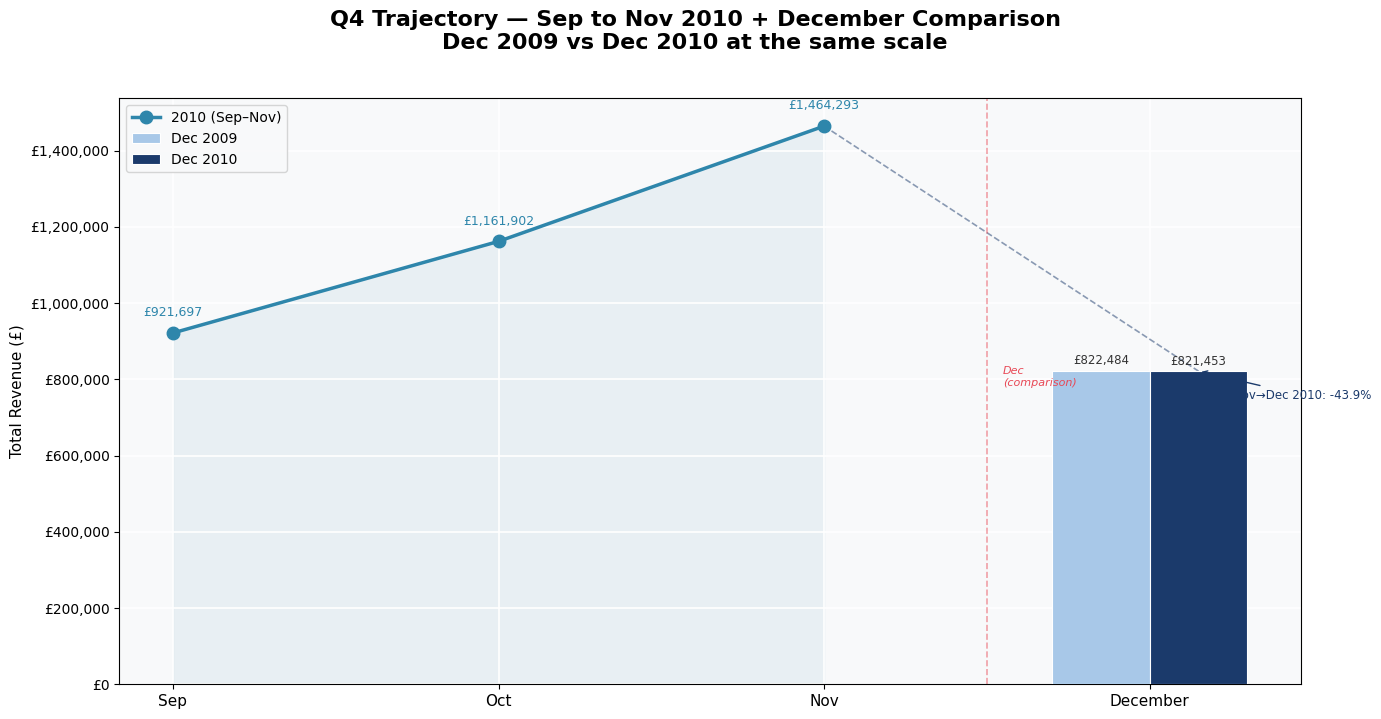


Nov 2010:  £1,464,293
Dec 2010:  £821,453  →  -43.9% vs Nov
Dec 2009:  £822,484

Note: Nov 2009 not available — cannot calculate Dec 2009 % change vs its Nov


In [28]:
# Q4 PATTERN + DECEMBER COMPARISON
# Line: Sep–Nov 2010 (the only complete Q4 we have)
# At December: two bars — Dec 2009 and Dec 2010
# Logic: if both Decembers behave the same relative to November,
# we can hypothesize Dec 2011 would follow the same pattern.

# Sep–Dec 2010 monthly totals
df_q4_2010 = df_clean[
    (df_clean['Year'] == 2010) &
    (df_clean['Month'].isin([9, 10, 11, 12]))
].groupby('Month')['Revenue'].sum().reset_index()

# Dec 2009
dec_2009_rev = df_clean[
    (df_clean['Year'] == 2009) &
    (df_clean['Month'] == 12)
]['Revenue'].sum()

month_labels = {9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec 2010'}
df_q4_2010['MonthLabel'] = df_q4_2010['Month'].map(month_labels)

nov_2010 = df_q4_2010[df_q4_2010['Month'] == 11]['Revenue'].values[0]
dec_2010 = df_q4_2010[df_q4_2010['Month'] == 12]['Revenue'].values[0]
diff_2010 = ((dec_2010 - nov_2010) / nov_2010 * 100).round(1)
diff_2009_vs_nov = "N/A — Nov 2009 not available"

# PLOT
fig, ax = plt.subplots(figsize=(14, 7))
fig.suptitle('Q4 Trajectory — Sep to Nov 2010 + December Comparison\n'
             'Dec 2009 vs Dec 2010 at the same scale', y=1.02)

# Line Sep–Nov 2010 (positions 0,1,2)
line_months = df_q4_2010[df_q4_2010['Month'] <= 11].sort_values('Month')
x_line = [0, 1, 2]
ax.plot(x_line, line_months['Revenue'],
        color=PALETTE['secondary'], linewidth=2.5,
        marker='o', markersize=9, label='2010 (Sep–Nov)', zorder=3)
ax.fill_between(x_line, line_months['Revenue'],
                alpha=0.08, color=PALETTE['secondary'])

for x, (_, row) in zip(x_line, line_months.iterrows()):
    ax.annotate(f"£{row['Revenue']:,.0f}",
                xy=(x, row['Revenue']),
                xytext=(0, 12), textcoords='offset points',
                ha='center', fontsize=9, color=PALETTE['secondary'])

# Two bars at position 3 for Dec 2009 and Dec 2010
width = 0.3
bar_2009 = ax.bar(3 - width/2, dec_2009_rev, width=width,
                   color=PALETTE['neutral'], edgecolor='white',
                   linewidth=0.8, label='Dec 2009', zorder=3)
bar_2010 = ax.bar(3 + width/2, dec_2010, width=width,
                   color=PALETTE['primary'], edgecolor='white',
                   linewidth=0.8, label='Dec 2010', zorder=3)

# Labels on bars
ax.text(3 - width/2, dec_2009_rev + dec_2009_rev*0.02,
        f'£{dec_2009_rev:,.0f}', ha='center', fontsize=8.5,
        color=PALETTE['text'])
ax.text(3 + width/2, dec_2010 + dec_2010*0.02,
        f'£{dec_2010:,.0f}', ha='center', fontsize=8.5,
        color=PALETTE['text'])

# Dotted line from Nov to Dec 2010 bar
ax.plot([2, 3 + width/2], [nov_2010, dec_2010],
        '--', color=PALETTE['primary'], linewidth=1.2, alpha=0.5)

# Vertical separator before December
ax.axvline(x=2.5, color=PALETTE['accent'], linewidth=1.2,
           linestyle='--', alpha=0.5)
ax.annotate('Dec\n(comparison)',
            xy=(2.55, ax.get_ylim()[0] if ax.get_ylim()[0] > 0
                else line_months['Revenue'].min() * 0.85),
            fontsize=8, color=PALETTE['accent'], style='italic')

# Nov→Dec 2010 change annotation
ax.annotate(f'Nov→Dec 2010: {diff_2010:+.1f}%',
            xy=(3 + width/2, dec_2010),
            xytext=(25, -20), textcoords='offset points',
            fontsize=8.5, color=PALETTE['primary'],
            arrowprops=dict(arrowstyle='->', color=PALETTE['primary'], lw=1))

ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['Sep', 'Oct', 'Nov', 'December'], fontsize=11)
ax.set_ylabel('Total Revenue (£)')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))
ax.legend(fontsize=10, loc='upper left')

plt.tight_layout()
plt.savefig('q4_december_hypothesis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nNov 2010:  £{nov_2010:,.0f}")
print(f"Dec 2010:  £{dec_2010:,.0f}  →  {diff_2010:+.1f}% vs Nov")
print(f"Dec 2009:  £{dec_2009_rev:,.0f}")
print(f"\nNote: Nov 2009 not available — cannot calculate Dec 2009 % change vs its Nov")

### December — Closing the open question

Two findings, both significant, and directly connected.

**Finding 1: December is a consistent pattern, not a one-off.**
Both available Decembers — 2009 (£822,484) and 2010 (£821,453) —
land at nearly identical revenue levels despite being a year apart.
The difference between them is less than £1,100 — statistically negligible.
This is not coincidence. Two Decembers producing virtually the same number
is the strongest signal available in this dataset that December
behaves as a structural, repeatable month.

**Finding 2: December resolves the hypothesis — it drops, and that drop has meaning.**
November 2010 closed at £1,464,293. December 2010 came in at £821,453 —
a -43.9% drop from the peak month.

This answers the question we posed earlier:
December does not continue the Q4 upward trajectory.
It pulls back sharply — to a level closer to the summer plateau
than to Q4's peaks.

**And this makes the full annual cycle coherent:**

> Sep → accelerating  
> Oct → climbing  
> Nov → peak  
> Dec → sharp pullback (~£820K both years)  
> Jan → moderate restart (~£650–690K)  

December's drop is not a collapse — it's a controlled reset.
The business pulls back from its November peak to a level that
sets up January's moderate start naturally.
The cycle closes cleanly.

**How confident are we?**
Two data points are not proof — but two Decembers producing
nearly identical revenue (£822K vs £821K) while November sits
£640K higher in both cases is a pattern worth stating clearly.

> *If a third year of data were available and December again
> landed near £820K, this would move from hypothesis to established pattern.
> With two years, it is the most strongly supported hypothesis
> this dataset can offer.*

### 6.3 Product Ranking Comparison — 2010 vs 2011

Do the same products lead both years, or does the ranking shift?
And for products that appear in both tops — did they grow with the business
or lose ground despite the overall revenue increase?

Products in both top 5: {'DOTCOM POSTAGE', 'WHITE HANGING HEART T-LIGHT HOLDER', 'REGENCY CAKESTAND 3 TIER'}


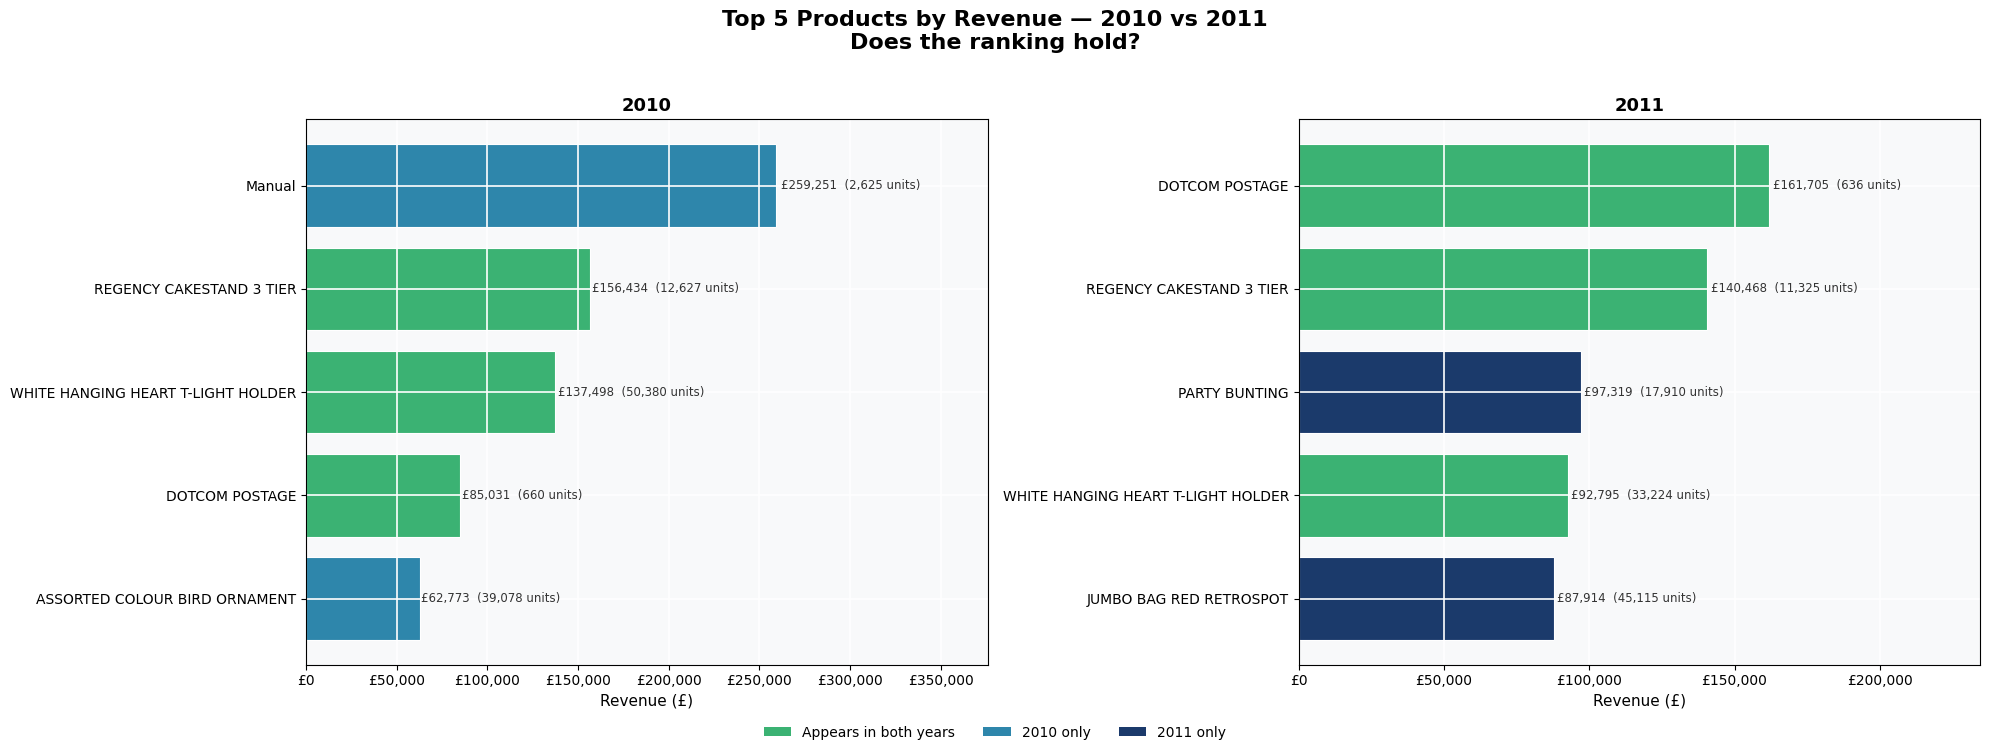


Top 5 — 2010:
                       Description   Revenue  Units
                            Manual 259251.08   2625
          REGENCY CAKESTAND 3 TIER 156433.78  12627
WHITE HANGING HEART T-LIGHT HOLDER 137498.15  50380
                    DOTCOM POSTAGE  85030.76    660
     ASSORTED COLOUR BIRD ORNAMENT  62772.94  39078

Top 5 — 2011:
                       Description   Revenue  Units
                    DOTCOM POSTAGE 161704.89    636
          REGENCY CAKESTAND 3 TIER 140467.66  11325
                     PARTY BUNTING  97319.01  17910
WHITE HANGING HEART T-LIGHT HOLDER  92795.48  33224
           JUMBO BAG RED RETROSPOT  87913.76  45115


In [29]:
# ── POINT 3: TOP 5 PRODUCTS — 2010 vs 2011 RANKING ───────────────
# We compare the top 5 revenue products of each year independently
# to see if the ranking is stable or rotates between years.

df_prod_yearly = df_monthly.groupby(['Year','Description']).agg(
    Revenue=('Revenue','sum'),
    Units=('Quantity','sum')
).reset_index()

top5_2010 = df_prod_yearly[df_prod_yearly['Year']==2010].nlargest(5,'Revenue').copy()
top5_2011 = df_prod_yearly[df_prod_yearly['Year']==2011].nlargest(5,'Revenue').copy()

# Tag products that appear in both tops
both = set(top5_2010['Description']) & set(top5_2011['Description'])
print(f"Products in both top 5: {both}")

fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=False)
fig.suptitle('Top 5 Products by Revenue — 2010 vs 2011\nDoes the ranking hold?', y=1.02)

for ax, data, year, color in [
    (axes[0], top5_2010, 2010, PALETTE['secondary']),
    (axes[1], top5_2011, 2011, PALETTE['primary'])
]:
    data = data.sort_values('Revenue', ascending=True).reset_index(drop=True)

    bar_colors = [
        PALETTE['positive'] if d in both
        else color
        for d in data['Description']
    ]

    bars = ax.barh(
        data['Description'].str[:35],
        data['Revenue'],
        color=bar_colors,
        edgecolor='white',
        linewidth=0.8
    )

    for bar, (_, row) in zip(bars, data.iterrows()):
        ax.text(
            bar.get_width() + bar.get_width()*0.01,
            bar.get_y() + bar.get_height()/2,
            f"£{row['Revenue']:,.0f}  ({row['Units']:,} units)",
            va='center', fontsize=8.5, color=PALETTE['text']
        )

    ax.set_title(str(year), fontsize=13)
    ax.set_xlabel('Revenue (£)')
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))
    ax.set_xlim(0, data['Revenue'].max() * 1.45)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=PALETTE['positive'], label='Appears in both years'),
    Patch(facecolor=PALETTE['secondary'],label='2010 only'),
    Patch(facecolor=PALETTE['primary'],  label='2011 only'),
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3,
           frameon=False, fontsize=10, bbox_to_anchor=(0.5, -0.04))

plt.tight_layout()
plt.savefig('product_ranking_2010_vs_2011.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 5 — 2010:")
print(top5_2010[['Description','Revenue','Units']].to_string(index=False))
print("\nTop 5 — 2011:")
print(top5_2011[['Description','Revenue','Units']].to_string(index=False))

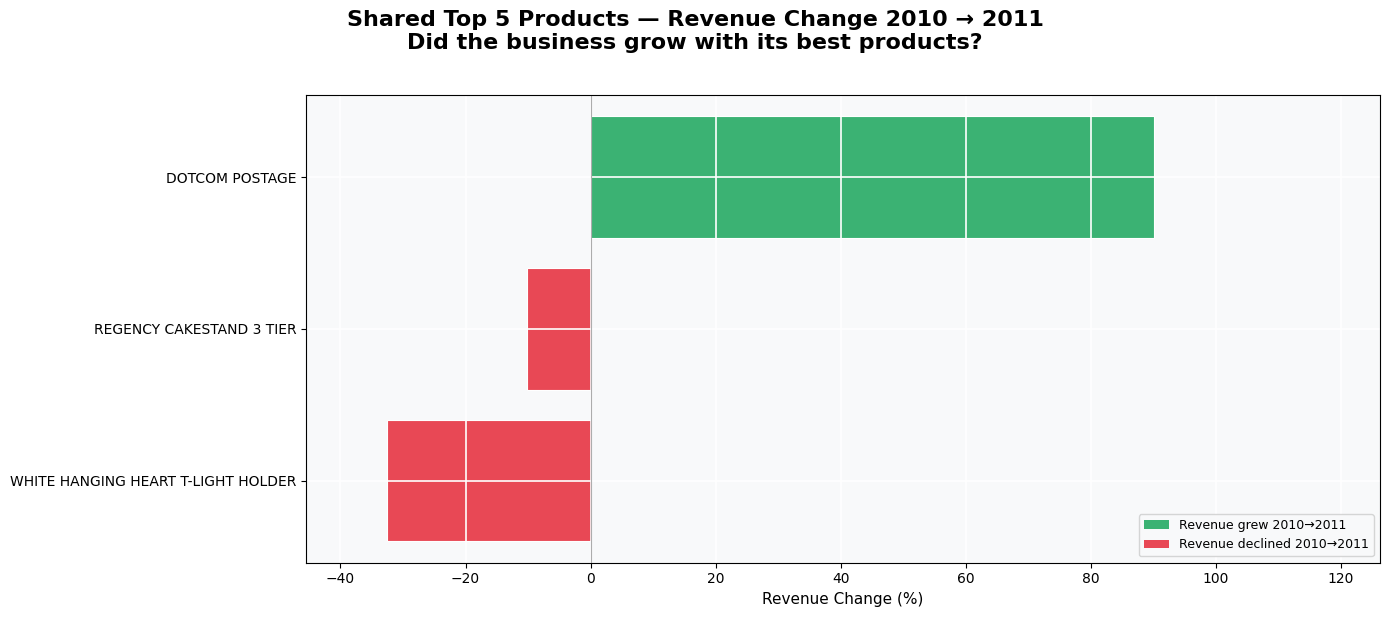


Shared products — Revenue change:
                       Description  Rev_2010  Rev_2011  Change £  Change %
WHITE HANGING HEART T-LIGHT HOLDER 137498.15  92795.48 -44702.67    -32.50
          REGENCY CAKESTAND 3 TIER 156433.78 140467.66 -15966.12    -10.20
                    DOTCOM POSTAGE  85030.76 161704.89  76674.13     90.20


In [31]:
fig, ax = plt.subplots(figsize=(14, 6))
fig.suptitle('Shared Top 5 Products — Revenue Change 2010 → 2011\n'
             'Did the business grow with its best products?', y=1.02)

bar_colors = [
    PALETTE['positive'] if v >= 0
    else PALETTE['accent']
    for v in pivot_shared['Change %']
]

bars = ax.barh(
    pivot_shared['Description'].str[:40],
    pivot_shared['Change %'],
    color=bar_colors,
    edgecolor='white',
    linewidth=0.8
)

ax.axvline(x=0, color=PALETTE['text'], linewidth=0.8, alpha=0.4)
ax.set_xlabel('Revenue Change (%)')
ax.set_xlim(
    pivot_shared['Change %'].min() * 1.4,
    pivot_shared['Change %'].max() * 1.4
)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=PALETTE['positive'], label='Revenue grew 2010→2011'),
    Patch(facecolor=PALETTE['accent'],   label='Revenue declined 2010→2011'),
]
ax.legend(handles=legend_elements, fontsize=9, loc='lower right')

plt.tight_layout()
plt.savefig('shared_products_growth.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nShared products — Revenue change:")
print(pivot_shared[['Description','Rev_2010','Rev_2011',
                     'Change £','Change %']].to_string(index=False))

### What the product ranking charts show — 2010 vs 2011

**The ranking is not stable — it rotates significantly between years.**

Of the five products that led in 2010, only three appear in 2011's top 5.
Two products dropped out entirely, replaced by PARTY BUNTING and
JUMBO BAG RED RETROSPOT — neither of which featured in 2010's top 5.

**The most striking movement: 2010's #1 disappeared from 2011's top 5 entirely.**
MANUAL entries led 2010 with £259,251 but do not appear in 2011's ranking at all.
This represents the largest single-product revenue shift between years.

**2010's #4 became 2011's #1 — with fewer units.**
DOTCOM POSTAGE jumped from fourth place to first despite selling
fewer units in 2011 (636 vs 660 in 2010).
Its revenue grew +90.2% — from £85,031 to £161,705.
Selling less and earning more has only one explanation:
a significant price increase per unit between years.
This is the clearest pricing signal in the entire dataset.

**The two products that held their position both declined in revenue.**
REGENCY CAKESTAND 3 TIER dropped -10.2% (£156,434 → £140,468).
WHITE HANGING HEART T-LIGHT HOLDER dropped -32.5% (£137,498 → £92,795) —
which directly explains its fall from 3rd to 4th place in 2011.

**What this means:**
The business's overall revenue growth from 2010 to 2011 was not driven
by its established top products performing better.
Two of the three shared products actually declined.
Growth came from a pricing decision on DOTCOM POSTAGE
and from new products entering the top 5 —
suggesting catalog rotation and pricing strategy,
not volume growth in existing winners, drove the year-over-year improvement.

> *A business can grow even when its best products decline —
> if new products emerge and pricing is adjusted strategically.
> That is exactly what this data shows.*

### 6.4 Country Dominance — Monthly Level

At the monthly level, including UK in a country comparison adds no information.
We already established that UK accounts for 84.5% of total revenue —
and the data confirms this holds every single month of both years,
ranging from 78.4% to 88.6% depending on the month.

Showing that UK leads January, February, March... through November
in both years is not a finding — it's a mathematical consequence
of a structural dominance already documented and visualized.

**The relevant question at the monthly level is different:**
Among international markets, does the same country lead every month —
or does leadership rotate depending on the time of year?
That's what the chart below investigates.

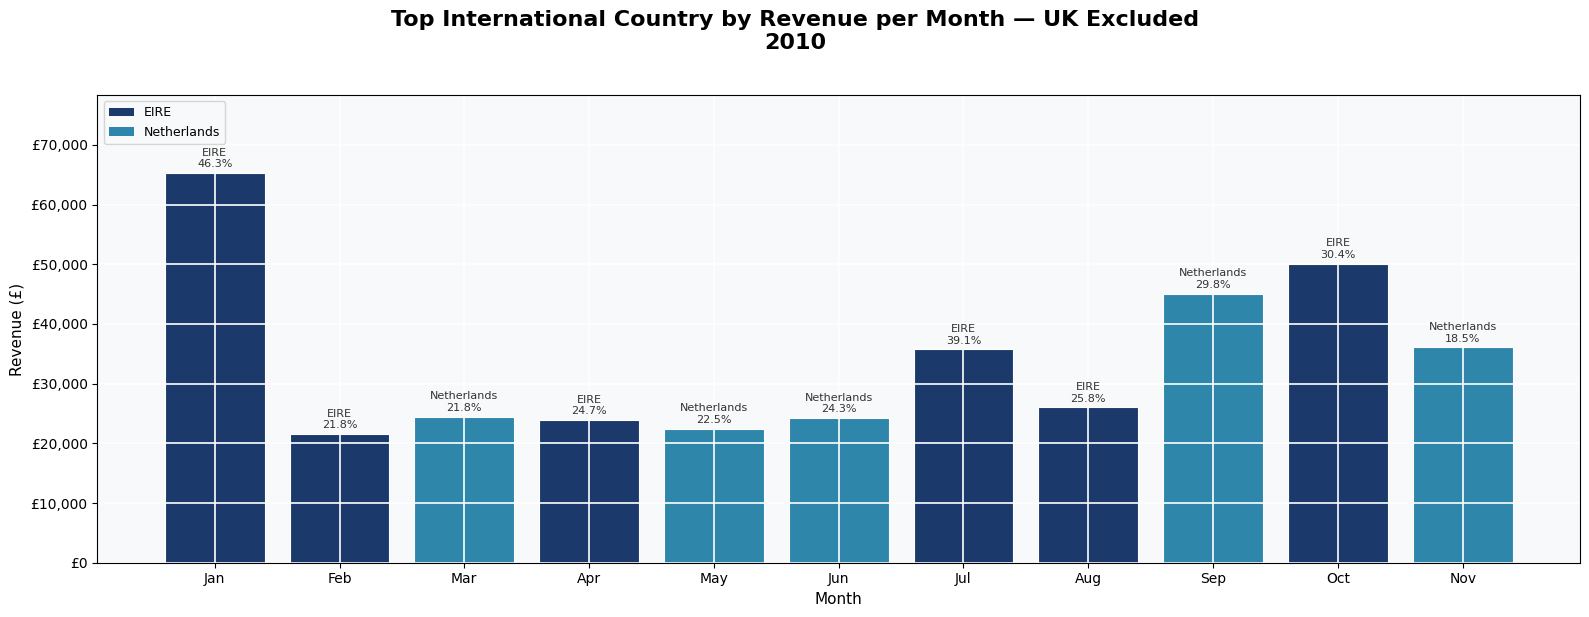


2010 — Top international country per month:
MonthName     Country  Revenue  Share %
      Jan        EIRE 65258.43    46.30
      Feb        EIRE 21538.80    21.80
      Mar Netherlands 24447.98    21.80
      Apr        EIRE 23904.58    24.70
      May Netherlands 22416.53    22.50
      Jun Netherlands 24224.51    24.30
      Jul        EIRE 35722.32    39.10
      Aug        EIRE 26005.71    25.80
      Sep Netherlands 45037.14    29.80
      Oct        EIRE 50079.05    30.40
      Nov Netherlands 36058.74    18.50


In [34]:
# ── MONTHLY COUNTRY — UK Excluded — 2010 ─────────────────────────
data_2010 = top_intl_monthly[top_intl_monthly['Year'] == 2010].sort_values('Month')

fig, ax = plt.subplots(figsize=(16, 6))
fig.suptitle('Top International Country by Revenue per Month — UK Excluded\n2010', y=1.02)

bar_colors = [country_colors.get(c, PALETTE['neutral']) for c in data_2010['Country']]
bars = ax.bar(
    data_2010['MonthName'].astype(str),
    data_2010['Revenue'],
    color=bar_colors,
    edgecolor='white',
    linewidth=0.8
)

max_val = data_2010['Revenue'].max()
for bar, (_, row) in zip(bars, data_2010.iterrows()):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + max_val*0.01,
        f"{row['Country']}\n{row['Share %']}%",
        ha='center', va='bottom', fontsize=8, color=PALETTE['text']
    )

ax.set_xlabel('Month')
ax.set_ylabel('Revenue (£)')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))
ax.set_ylim(0, max_val * 1.2)

from matplotlib.patches import Patch
countries_2010 = data_2010['Country'].unique()
legend_elements = [
    Patch(facecolor=country_colors.get(c, PALETTE['neutral']), label=c)
    for c in countries_2010
]
ax.legend(handles=legend_elements, fontsize=9, loc='upper left')

plt.tight_layout()
plt.savefig('monthly_country_no_uk_2010.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n2010 — Top international country per month:")
print(data_2010[['MonthName','Country','Revenue','Share %']].to_string(index=False))

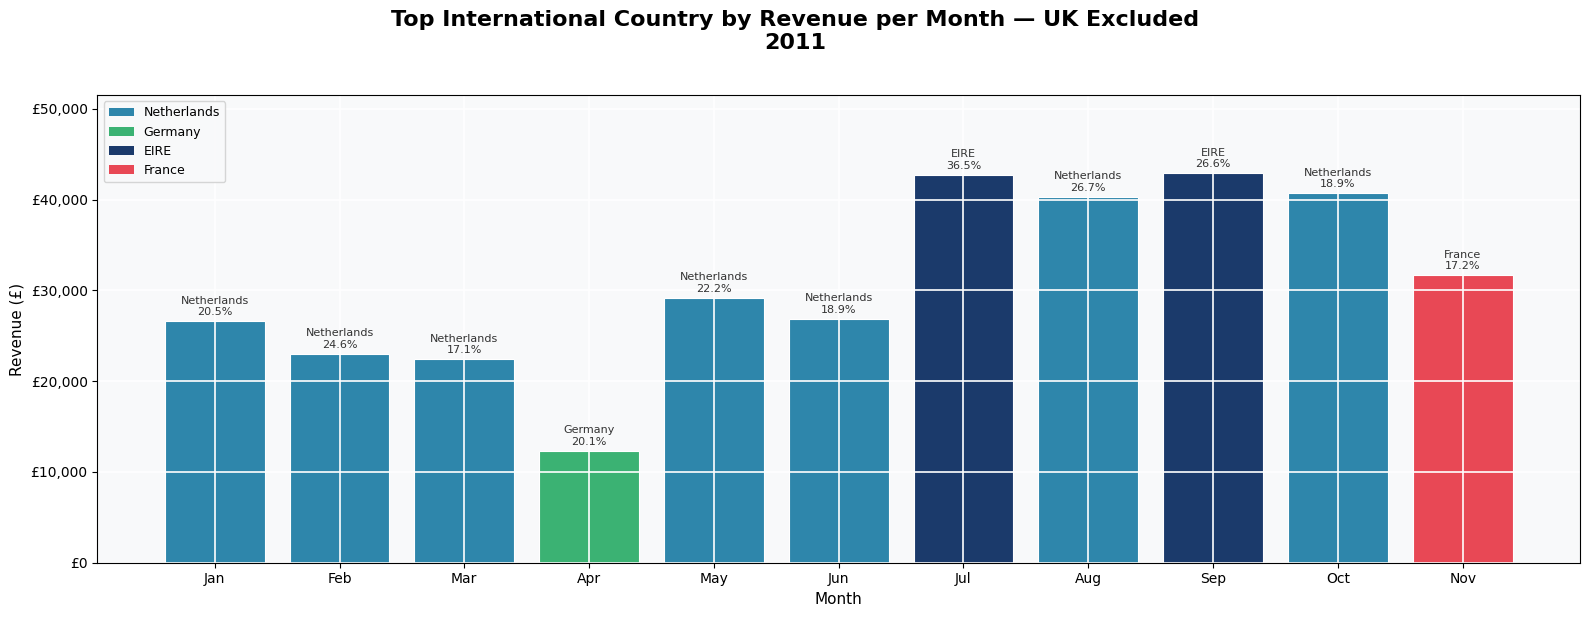


2011 — Top international country per month:
MonthName     Country  Revenue  Share %
      Jan Netherlands 26611.16    20.50
      Feb Netherlands 23011.91    24.60
      Mar Netherlands 22416.49    17.10
      Apr     Germany 12315.54    20.10
      May Netherlands 29185.88    22.20
      Jun Netherlands 26858.09    18.90
      Jul        EIRE 42738.85    36.50
      Aug Netherlands 40327.81    26.70
      Sep        EIRE 42923.70    26.60
      Oct Netherlands 40708.65    18.90
      Nov      France 31696.37    17.20


In [35]:
# ── MONTHLY COUNTRY — UK Excluded — 2011 ─────────────────────────
data_2011 = top_intl_monthly[top_intl_monthly['Year'] == 2011].sort_values('Month')

fig, ax = plt.subplots(figsize=(16, 6))
fig.suptitle('Top International Country by Revenue per Month — UK Excluded\n2011', y=1.02)

bar_colors = [country_colors.get(c, PALETTE['neutral']) for c in data_2011['Country']]
bars = ax.bar(
    data_2011['MonthName'].astype(str),
    data_2011['Revenue'],
    color=bar_colors,
    edgecolor='white',
    linewidth=0.8
)

max_val = data_2011['Revenue'].max()
for bar, (_, row) in zip(bars, data_2011.iterrows()):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + max_val*0.01,
        f"{row['Country']}\n{row['Share %']}%",
        ha='center', va='bottom', fontsize=8, color=PALETTE['text']
    )

ax.set_xlabel('Month')
ax.set_ylabel('Revenue (£)')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))
ax.set_ylim(0, max_val * 1.2)

countries_2011 = data_2011['Country'].unique()
legend_elements = [
    Patch(facecolor=country_colors.get(c, PALETTE['neutral']), label=c)
    for c in countries_2011
]
ax.legend(handles=legend_elements, fontsize=9, loc='upper left')

plt.tight_layout()
plt.savefig('monthly_country_no_uk_2011.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n2011 — Top international country per month:")
print(data_2011[['MonthName','Country','Revenue','Share %']].to_string(index=False))

### What the international monthly charts show

**2010: Two countries share the international leadership.**
EIRE and Netherlands alternate month by month throughout the year —
EIRE leads in January, February, April, July, August and October,
Netherlands leads in March, May, June, September and November.
No other country appears as monthly leader in 2010.
The international market outside UK is effectively a two-country dynamic.

**2011: Leadership diversifies across four countries.**
Netherlands dominates the first half of the year (Jan–Mar, May–Jun, Aug, Oct),
but EIRE reclaims leadership in July and September,
Germany leads April, and France emerges as the top international
market in November — a country that never led a single month in 2010.

This is a meaningful structural shift: in 2010 the international market
was a bilateral competition between EIRE and Netherlands.
In 2011 it became a multi-market landscape with four different
countries reaching the top position at different points in the year.

**Whether this diversification contributed to 2011's higher overall revenue
is plausible but cannot be confirmed from this data alone.**
What we can confirm is that the international market became less
concentrated in 2011 — and that is a commercially relevant observation
regardless of causality.

## 7. Annual Analysis

The annual level is where everything consolidates.
Rather than repeating what's already been documented —
product rankings and country dominance are fully analyzed
in the monthly and weekly sections above —
we focus here on two specific questions:

1. What was the total revenue difference between 2010 and 2011?
2. Does the month-by-month shape of both years confirm
   the structural patterns we identified, or does it reveal something new?

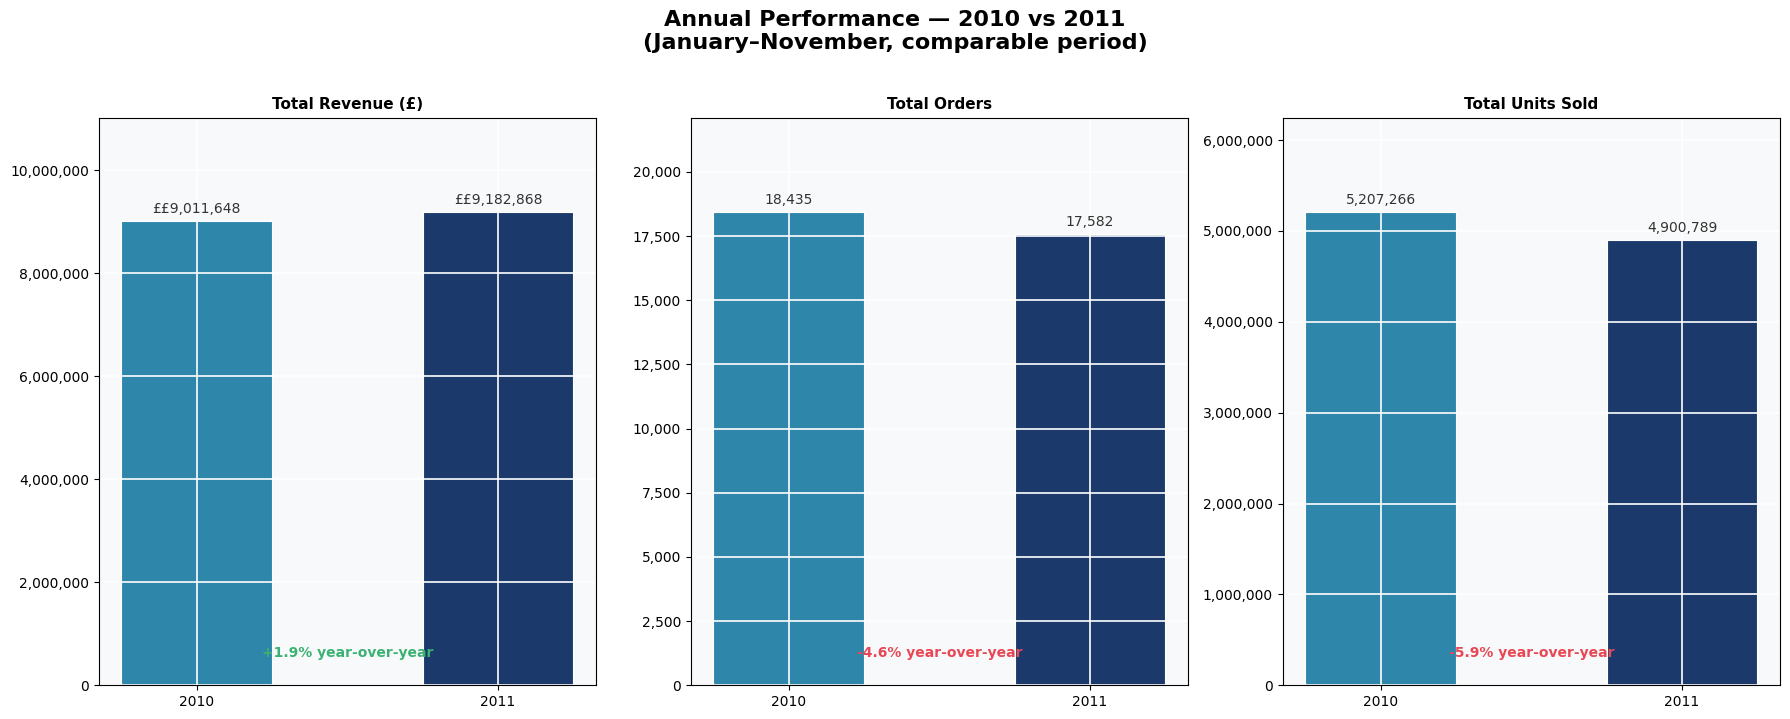


Annual Summary:
 Year    Revenue  Transactions   Units
 2010 9011647.69         18435 5207266
 2011 9182867.74         17582 4900789

Revenue growth:      +1.9%
Transaction growth:  -4.6%
Units growth:        -5.9%


In [36]:
# ANNUAL ANALYSIS — Point 1: Total revenue comparison
annual = df_monthly.groupby('Year').agg(
    Revenue=('Revenue','sum'),
    Transactions=('Invoice','nunique'),
    Units=('Quantity','sum')
).reset_index()

growth_rev = ((annual.loc[annual['Year']==2011,'Revenue'].values[0] -
               annual.loc[annual['Year']==2010,'Revenue'].values[0]) /
               annual.loc[annual['Year']==2010,'Revenue'].values[0] * 100).round(1)

growth_trans = ((annual.loc[annual['Year']==2011,'Transactions'].values[0] -
                 annual.loc[annual['Year']==2010,'Transactions'].values[0]) /
                 annual.loc[annual['Year']==2010,'Transactions'].values[0] * 100).round(1)

growth_units = ((annual.loc[annual['Year']==2011,'Units'].values[0] -
                 annual.loc[annual['Year']==2010,'Units'].values[0]) /
                 annual.loc[annual['Year']==2010,'Units'].values[0] * 100).round(1)

fig, axes = plt.subplots(1, 3, figsize=(18, 7))
fig.suptitle('Annual Performance — 2010 vs 2011\n(January–November, comparable period)', y=1.02)

metrics = [
    (axes[0], 'Revenue',      '£',  growth_rev,   'Total Revenue (£)'),
    (axes[1], 'Transactions', '',   growth_trans,  'Total Orders'),
    (axes[2], 'Units',        '',   growth_units,  'Total Units Sold'),
]

for ax, metric, prefix, growth, title in metrics:
    bars = ax.bar(
        ['2010','2011'],
        annual[metric],
        color=[PALETTE['secondary'], PALETTE['primary']],
        edgecolor='white',
        linewidth=0.8,
        width=0.5
    )
    for bar, (_, row) in zip(bars, annual.iterrows()):
        val = f"{prefix}£{row[metric]:,.0f}" if prefix == '£' else f"{row[metric]:,.0f}"
        ax.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + annual[metric].max()*0.01,
            val,
            ha='center', va='bottom', fontsize=10, color=PALETTE['text']
        )
    ax.set_title(title, fontsize=11)
    ax.set_ylim(0, annual[metric].max() * 1.2)
    ax.yaxis.set_major_formatter(
        plt.FuncFormatter(lambda x, _: f'£{x:,.0f}' if metric=='Revenue' else f'{x:,.0f}')
    )
    color = PALETTE['positive'] if growth >= 0 else PALETTE['accent']
    ax.annotate(f'{growth:+.1f}% year-over-year',
                xy=(0.5, 0.05), xycoords='axes fraction',
                ha='center', fontsize=10, color=color, fontweight='bold')

plt.tight_layout()
plt.savefig('annual_total_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nAnnual Summary:")
print(annual.to_string(index=False))
print(f"\nRevenue growth:      {growth_rev:+.1f}%")
print(f"Transaction growth:  {growth_trans:+.1f}%")
print(f"Units growth:        {growth_units:+.1f}%")

### What the annual numbers reveal

**2011 generated more revenue with fewer transactions and fewer units sold.**

| Metric | 2010 | 2011 | Change |
|--------|------|------|--------|
| Revenue | £9,011,648 | £9,182,868 | +1.9% |
| Orders | 18,435 | 17,582 | -4.6% |
| Units sold | 5,207,266 | 4,900,789 | -5.9% |

At first glance this seems contradictory.
In practice, it is the most coherent finding in the entire dataset.

**Every level of analysis points to the same explanation:**

At the weekly level, Thursday's dominance was driven by revenue,
not volume — suggesting higher-value orders, not more orders.

At the product level, DOTCOM POSTAGE became the top revenue product
in 2011 while selling fewer units — a direct pricing increase signal.
The two products shared across both top 5s declined in units
but the overall revenue held.

At the country level, 2011 showed greater international market diversity —
four countries reaching monthly leadership vs two in 2010.
More markets, each potentially ordering at different price points,
contributing to revenue without inflating transaction count.

**The conclusion that ties it all together:**
The business grew in 2011 not by selling more, but by selling better —
higher prices per unit, broader international reach,
and a product mix that extracted more value from fewer transactions.

> *Volume fell. Revenue rose. That is not a paradox —
> it is a pricing and market strategy working as intended.*

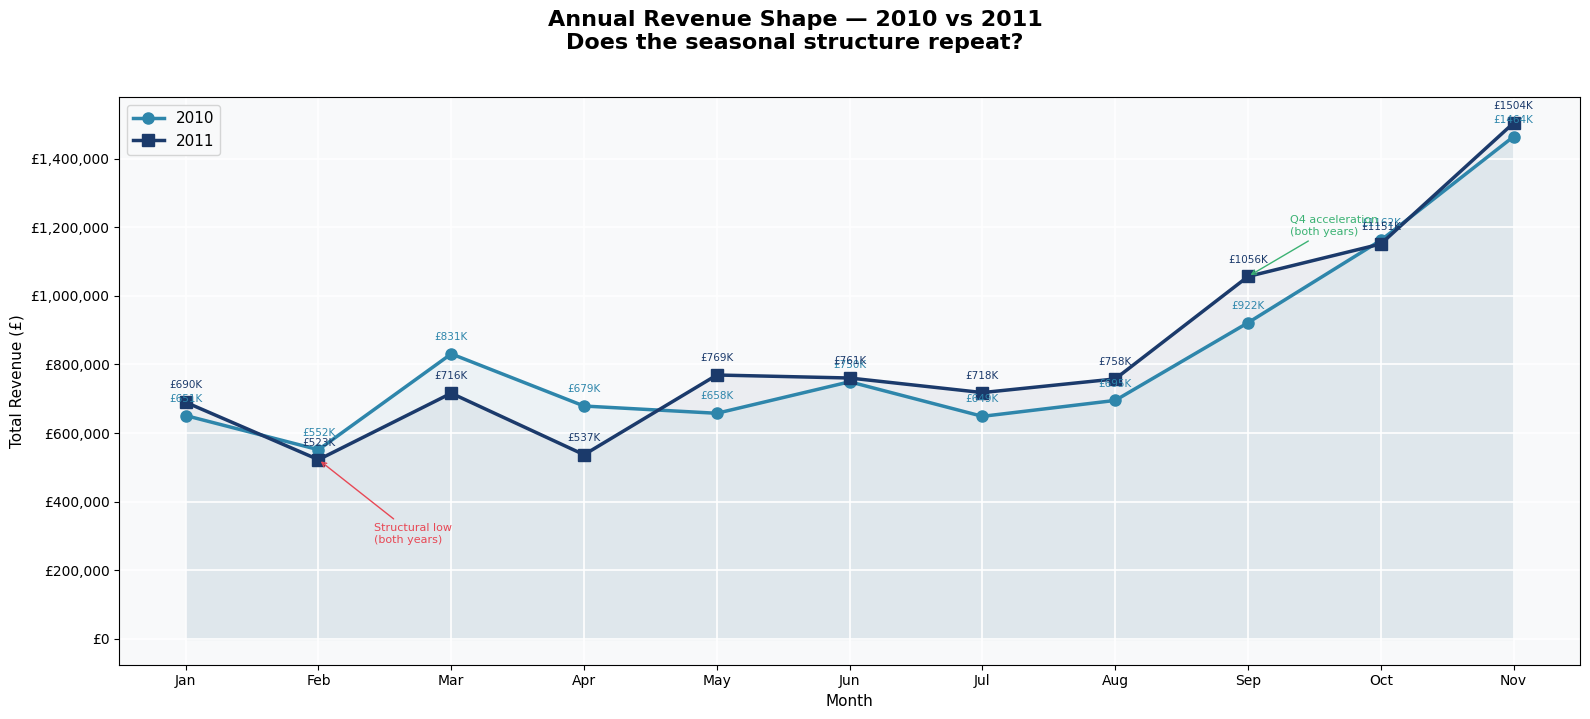

In [37]:
# ANNUAL ANALYSIS — Point 3: Monthly shape overlay
# Both years plotted as lines to confirm whether the structural
# seasonal pattern holds at the annual level of comparison.

monthly_shape = df_monthly.groupby(['Year','Month','MonthName'])['Revenue'].sum().reset_index()
monthly_shape['MonthName'] = pd.Categorical(
    monthly_shape['MonthName'], categories=month_order, ordered=True)
monthly_shape = monthly_shape.sort_values(['Year','Month'])

fig, ax = plt.subplots(figsize=(16, 7))
fig.suptitle('Annual Revenue Shape — 2010 vs 2011\nDoes the seasonal structure repeat?', y=1.02)

for year, color, marker in [
    (2010, PALETTE['secondary'], 'o'),
    (2011, PALETTE['primary'],   's')
]:
    data = monthly_shape[monthly_shape['Year'] == year]
    ax.plot(
        data['MonthName'].astype(str),
        data['Revenue'],
        color=color, marker=marker,
        linewidth=2.5, markersize=8,
        label=str(year)
    )
    ax.fill_between(
        data['MonthName'].astype(str),
        data['Revenue'],
        alpha=0.06, color=color
    )
    for _, row in data.iterrows():
        ax.annotate(
            f"£{row['Revenue']/1000:.0f}K",
            xy=(row['MonthName'], row['Revenue']),
            xytext=(0, 10), textcoords='offset points',
            ha='center', fontsize=7.5, color=color
        )

ax.set_xlabel('Month')
ax.set_ylabel('Total Revenue (£)')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'£{x:,.0f}'))
ax.legend(fontsize=11)

# Annotate Feb dip and Q4 rise
ax.annotate('Structural low\n(both years)',
            xy=('Feb', monthly_shape[monthly_shape['Month']==2]['Revenue'].min()),
            xytext=(40, -60), textcoords='offset points',
            fontsize=8, color=PALETTE['accent'],
            arrowprops=dict(arrowstyle='->', color=PALETTE['accent'], lw=1))

ax.annotate('Q4 acceleration\n(both years)',
            xy=('Sep', monthly_shape[monthly_shape['Month']==9]['Revenue'].max()),
            xytext=(30, 30), textcoords='offset points',
            fontsize=8, color=PALETTE['positive'],
            arrowprops=dict(arrowstyle='->', color=PALETTE['positive'], lw=1))

plt.tight_layout()
plt.savefig('annual_shape_overlay.png', dpi=150, bbox_inches='tight')
plt.show()

### Annual revenue shape — confirmed structural pattern

This chart consolidates every seasonal observation made across
the weekly and monthly analyses into a single visual.

The two lines follow the same trajectory with remarkable consistency:

**January** — moderate start, both years within £30K of each other  
**February** — structural low, both years drop to their annual floor  
**March** — recovery above January's level in both years  
**April** — secondary dip, both years pull back from March  
**May–August** — plateau, both lines run nearly parallel  
**September onward** — Q4 acceleration begins, both lines climb  
**November** — peak in both years, lines converge at their highest point  

**This is not two years of data — this is one pattern, observed twice.**

The business operates on a highly predictable annual cycle.
February is the structural floor. November is the structural ceiling.
The path between them — dip, recovery, plateau, acceleration —
repeats without meaningful deviation across both years.

The only difference between the two lines is scale:
2011 runs slightly above 2010 from June onward,
consistent with the pricing and market diversification
documented in the annual comparison above.

> *A business with a pattern this stable and this repeatable
> is a business that can be planned around.
> Inventory, staffing, marketing investment — all of these
> decisions become significantly easier when the seasonal
> structure is this predictable.*

## 8. Confirmed Patterns — What the Data Repeats

The following patterns are not isolated observations.
Each one was observed consistently across multiple time periods,
multiple levels of analysis, or both years of data.
They form the analytical foundation for the recommendations that follow.

---

### Weekly patterns

**1. Sunday is the structural weekly low.**
Revenue drops between 37% and 62% below the weekday average
every Sunday, in both H1 and H2, in both 2010 and 2011.
This is the most consistent single finding in the dataset.

**2. Thursday is the dominant revenue day.**
Peak day in H1 2010, H2 2011, and confirmed as the leading day
across the top 5 products by both revenue and units sold.

**3. H2 always outperforms H1.**
Every day of the week generates higher revenue in the second half
of the year than in the first — in both 2010 and 2011, without exception.

**4. The weekly pattern is structurally stable across both years.**
Same shape, same Sunday floor, same Thursday dominance.
The business follows a consistent weekly rhythm regardless of the year.

---

### Monthly patterns

**5. February is the structural monthly low.**
The lowest-revenue month in both 2010 and 2011, without exception.

**6. November is the structural monthly peak.**
The highest-revenue month in both 2010 and 2011, without exception.

**7. The annual cycle is identical across both years.**
Moderate start → February dip → March recovery →
April–August plateau → Q4 acceleration → November peak.
Two years, one pattern.

**8. December resets below November — consistently.**
December 2009: £822,484. December 2010: £821,453.
A difference of less than £1,100 across two separate years.
December does not continue November's climb — it pulls back
to a level that sets up January's moderate restart.

**9. Revenue and volume are driven by different products.**
The top revenue product and the top volume product are never the same.
Confirmed at the weekly, monthly, and December standalone levels.

---

### Product patterns

**10. November is the peak month for top-performing products.**
4 out of 5 top products by units sold peak in November —
consistent with the overall monthly structure.

**11. High volume does not guarantee high revenue.**
Across every level of analysis, products with the highest unit counts
do not lead in revenue generation. Price per unit is the differentiating factor.

---

### Annual patterns

**12. The business grew by selling at higher prices, not higher volumes.**
2011 vs 2010: revenue +1.9%, orders -4.6%, units -5.9%.
More money from fewer transactions — a consistent pricing signal.

**13. UK dominates structurally and without exception.**
84.5% of total revenue, confirmed across every month of both years.

**14. EIRE and Netherlands are the most consistent international markets.**
The only two countries to lead international revenue in 2010.
Both remain relevant in 2011, though leadership diversifies
to include Germany and France as the international market matures.

## 9. Pattern Classification — Problems, Benefits, and Neutral Facts

Not every pattern requires a solution.
Before making recommendations, it's important to be explicit about
which patterns represent problems, which are strengths to protect,
and which are neutral facts whose impact depends on context.

---

### Patterns that are business strengths

**#6 — November is the structural peak.**
The business has a natural, consistent revenue ceiling every year.
This is commercially valuable — it enables planning, inventory decisions,
and staffing with high confidence.

**#3 — H2 always outperforms H1.**
The second half of the year is structurally stronger.
Combined with the November peak, this gives the business
a reliable window of high performance to build around.

**#10 — Top products peak in November.**
Product performance aligns with the overall seasonal structure.
The catalog and the calendar work together, not against each other.

**#13 — UK dominates structurally.**
84.5% of revenue from a single, stable domestic market
is a strong and predictable foundation.

**#14 — EIRE and Netherlands are consistent international markets.**
Two reliable international markets that perform across both years
provide a stable base for international expansion.

**#12 — The business grew by selling at higher prices with more diversity.**
Revenue grew while volume fell — but this happened alongside
greater product diversity and broader international market reach.
This is not inefficiency. It is a sign of commercial maturity:
the business is extracting more value per transaction
while simultaneously expanding its customer base.
The only caveat: if unit volume continues to decline in future years,
this pattern would warrant closer attention.
For now, it is a strength.

---

### Patterns that represent problems or risks

**#1 — Sunday is the structural weekly low.**
Revenue drops between 37% and 62% every Sunday without exception.
This may reflect the wholesale nature of the customer base,
but it also represents a consistent gap in weekly performance
that compounds across 52 weeks per year.

**#5 — February is the structural monthly low.**
A pronounced and systematic drop at the start of every year.
No month recovers February's lost ground until March —
meaning the business enters each year with a weak first quarter anchor.

**#8 — December resets sharply below November.**
The year closes with a -43.9% drop from its peak month.
While December still generates meaningful revenue,
the transition from November's high to December's reset
to January's moderate start creates a three-month soft period
at the year's boundary.

**#9 / #11 — Revenue and volume are never driven by the same product.**
Across every level of analysis, no single product leads in both metrics.
This means the business has no anchor product —
one that combines high demand with high value.
That is a catalog vulnerability: if the top revenue product loses ground,
there is no high-volume product ready to compensate, and vice versa.

**#7 — April through August is a four-month plateau.**
Five consecutive months where revenue neither grows nor declines meaningfully.
In a business with a strong Q4, this mid-year stagnation
represents the largest untapped revenue window of the year.

---

### Summary

| Pattern | Classification |
|---------|---------------|
| November peak |  Strength |
| H2 outperforms H1 |  Strength |
| Top products peak in November |  Strength |
| UK dominance |  Strength |
| EIRE & Netherlands consistency |  Strength |
| Growth by price + diversity |  Strength (monitor volume trend) |
| Sunday structural low |  Problem! |
| February structural low |  Problem! |
| December post-November drop |  Problem! |
| Revenue ≠ Volume products |  Problem! |
| April–August plateau |  Problem! |

## 10. Final Conclusions — A Business That Knows Its Model

Throughout this analysis we examined over 980,000 transactions
across two full years, at three levels of granularity:
weekly, monthly, and annual.

We identified 14 recurring patterns — things that happened not once,
but consistently, across time periods and metrics.
We then asked the right question: are these problems to solve,
or facts to understand?

**The answer is the latter.**

Every pattern that initially appeared as a weakness —
the Sunday floor, the February dip, the mid-year plateau,
the December reset, the divergence between revenue and volume —
dissolves as a problem the moment you frame it correctly:

**This is a wholesale business. It sells to those who sell.**

That single fact explains everything:

- Sunday is quiet because wholesale buyers don't place orders on Sundays
- February drops because clients stocked up in H2 of the previous year
- April through August plateaus because clients are consuming that stock
- September accelerates because stock is running out and reordering begins
- November peaks because clients are building inventory for the coming year
- December resets because the buying cycle has closed for the year

These are not failures of the business.
They are proof that the business operates in synchrony
with the commercial rhythm of its clients.

**The diversity finding reinforces this.**
2011 was more diverse in products and in markets.
It sold fewer units. It generated more revenue.
A rigid business optimized around a single product or a single market
would have been more vulnerable to any shift in demand.
This business absorbed that shift and grew anyway —
because flexibility was built into its structure.

**What two years of data confirm:**

The business has a stable, predictable, and coherent annual cycle.
It has a reliable domestic foundation in UK,
a growing international presence led by EIRE and Netherlands,
a product catalog diverse enough to smooth seasonal variation,
and a pricing strategy that extracted more value in 2011
without sacrificing market breadth.

> *The patterns in this data do not describe a business that needs fixing.
> They describe a business that understands what it is,
> who it sells to, and how to operate within a cycle it does not control
> — and that is a considerably harder thing to achieve
> than simply selling more units.*